# Figure 1 & S1

This notebook provides code for reproducing Figures 1 and S1 from Yang\*, Jones\* et al, _bioRxiv_ 2021.

In [2]:
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import seaborn as sns
#
# 
#from cassiopeia.TreeSolver.Node import Node
#sys.path.append("/WorkDir4/yanzeqin/220823_A00403_0863_AHMNGLDSX3/Script/KPTracer-release-main/cassiopeia-kp/cassiopeia") 

sys.path.append("/WorkDir4/yanzeqin/220823_A00403_0863_AHMNGLDSX3/Script/KPTracer-release-main/cassiopeia-kp/cassiopeia/ProcessingPipeline/process")
sys.path.append("/WorkDir4/yanzeqin/soft/Cassiopeia/cassiopeia/preprocess")
sys.path.append("/WorkDir4/yanzeqin/soft/Cassiopeia")
#import cassiopeia.preprocess.lineage_utils as lg_util
sys.path.append("/WorkDir4/yanzeqin/220823_A00403_0863_AHMNGLDSX3/Script/KPTracer-release-main/cassiopeia-kp")
#import cassiopeia.ProcessingPipeline.process.lineageGroup as lg_util


from tqdm import tqdm_notebook

In [3]:

sys.path.append("/WorkDir4/yanzeqin/220823_A00403_0863_AHMNGLDSX3/Script/KPTracer-release-main/cassiopeia-kp/")
import cassiopeia.TreeSolver.utilities as util

In [4]:
sys.path.append("/WorkDir4/yanzeqin/220823_A00403_0863_AHMNGLDSX3/Script/KPTracer-release-main/cassiopeia-kp")
import cassiopeia.ProcessingPipeline.process.lineageGroup as lg_util

## Process unfiltered allele table & identify consensus intBCs

Here we will demonstrate how to convert allele tables into character matrices, filter out "normal" cells identified from a lack of Cas9 activity, and subset the full set of intBCs to a small "consensus" set observed consistently across tumors from the same clone.

In [7]:
# 获取当前脚本所在目录
script_dir = "/WorkDir4/yanzeqin/220823_A00403_0863_AHMNGLDSX3/Script/AP-data/allele_new"

# 将当前工作目录设置为脚本所在目录
#os.chdir(script_dir)

data_directory = "/WorkDir4/yanzeqin/220823_A00403_0863_AHMNGLDSX3/Script/AP-data/allele_new"

In [8]:
allele_table_unfiltered = pd.read_csv(f"{data_directory}/AP.alleleTable.unfiltered.txt2", sep='\t')
trcr_master = pd.read_csv(f"{data_directory}/trce.txt", sep='\t')
meta = pd.read_csv(f"{data_directory}/mete.csv", sep=',', index_col = 0)
tumor_list = pd.read_csv(f"{data_directory}/tumor_list.txt", sep='\t')
meta.index.name = None

In [9]:
def compute_perc_indels(cm):

    all_vals = cm.values.ravel()
    num_not_missing = len([n for n in all_vals if n != '-'])
    num_uncut = len([n for n in all_vals if n == '0'])

    return 1.0 - (num_uncut / num_not_missing)

def percent_uncut(x):
    uncut = 0
    for i in x:
        if i == '0':
            uncut += 1
    return uncut / max(1, len([i for i in x if i != '-']))

def drop_exhausted_targets(cm, p = 0.98):
    
    to_drop = []
    for col in cm.columns:
        states = cm[col].values
        uniq_vals = [val for val in states if val != '0' and val != '-']
        total_nonmissing = len([val for val in states if val != '-'])
        
        unique, counts = np.unique(uniq_vals, return_counts=True)
        
        counts = np.array(counts) / total_nonmissing
        
        if np.max(counts) >= p:
            to_drop.append(col)
            
    return to_drop

In [10]:
meta

,cellBC,X10x_Lane,Tumor,Cell_Clone,Genotype,MouseID,Aging_Month,Batch_Library,Batch_Harvest,Aging_day
CTR_MGH.CAATTTCGTGGCTAGA,CTR_MGH.CAATTTCGTGGCTAGA,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
CTR_MGH.ATACTTCGTGCAAGAC,CTR_MGH.ATACTTCGTGCAAGAC,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
CTR_MGH.TCATCATGTTGGAGAC,CTR_MGH.TCATCATGTTGGAGAC,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
CTR_MGH.GTTGTCCAGGCTGGAT,CTR_MGH.GTTGTCCAGGCTGGAT,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
CTR_MGH.TTTCCTCAGACATAAC,CTR_MGH.TTTCCTCAGACATAAC,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
...,...,...,...,...,...,...,...,...,...,...
NMI_MGH.GTGAGCCAGAAGCTCG,NMI_MGH.GTGAGCCAGAAGCTCG,L3,NMI_MGH_6,C1,NMIBC,M-12,3,NaN,NaN,98
NMI_MGH.GGGAGATGTTCTATCT,NMI_MGH.GGGAGATGTTCTATCT,L3,NMI_MGH_6,C1,NMIBC,M-12,3,NaN,NaN,98
NMI_MGH.CATGCGGGTGAGCTCC,NMI_MGH.CATGCGGGTGAGCTCC,L3,NMI_MGH_6,C1,NMIBC,M-12,3,NaN,NaN,98
NMI_MGH.GTCCCATAGTATAACG,NMI_MGH.GTCCCATAGTATAACG,L3,NMI_MGH_6,C1,NMIBC,M-12,3,NaN,NaN,98


In [11]:
keep_cellbcs = []
error_tumors = []

for tumor, tumor_at in allele_table_unfiltered.groupby('Tumor'):
    clone = meta.loc[meta['Tumor'] == tumor, 'Cell_Clone'].iloc[0]

    #if type(clone) != str:
    #    continue

    #if 'All' in tumor or 'Met' in tumor or "Fam" in tumor:
    #    continue

    #if 'Normal' in tumor or 'Imm' in tumor:
    #    continue

    lg = lg_util.collectAlleles(tumor_at, thresh=0.2)[0]
    
    try:
        cm2, priors, state2indel = util.alleletable_to_character_matrix(lg, write=False, mutation_map = None, allele_rep_thresh = 0.98)
    except:
        cm2, priors, state2indel = util.alleletable_to_character_matrix(lg, write=False, mutation_map = None, allele_rep_thresh = 1.0)
        
    pu = cm2.apply(lambda x: percent_uncut(x.values), axis=1)

    cmf = cm2[pu < 0.8]
    
    cellbcs = cmf.index.values
    
    #meta.loc[dict(zip(pu.index, pu.values)), 'percent_uncut'] = pu.values

    keep_cellbcs += list(cellbcs)

100%|██████████| 1/1 [00:00<00:00, 149.55it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CTTCTGTCCTGCA_r3', 'CCCGAACATTTCC_r3', 'TCTCCTAATTGAA_r3', 'CATGGTTGAGCAT_r1', 'CATGGTTGAGCAT_r3', 'ACAGCGCCTGTAT_r3', 'ACAGGGTATCAGT_r3', 'ACGCTCTCTGGAC_r2', 'ACGCTCTCTGGAC_r3', 'CGTGTGGCGAGCA_r1', 'TGTGTCGCATCTG_r2', 'TGTGTCGCATCTG_r3', 'GGCGAATTTAATC_r1', 'GGCGAATTTAATC_r3', 'TATGACGGTAGCG_r1', 'TATGACGGTAGCG_r2', 'TCTGTCTATTAAC_r1', 'TCTGTCTATTAAC_r2', 'TCTGTCTATTAAC_r3', 'GGCCAATGGATGA_r1']


100%|██████████| 1/1 [00:00<00:00, 82.27it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GAGTGGATATGGG_r1', 'GAGTGGATATGGG_r2', 'GAGTGGATATGGG_r3', 'TCTGAGTCCTTAG_r1', 'TCTGAGTCCTTAG_r2', 'TATGCCATGGCGA_r2', 'TATGCCATGGCGA_r3']


100%|██████████| 1/1 [00:00<00:00, 76.78it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AACGTTCCGGGGT_r1', 'AACGTTCCGGGGT_r2', 'AACGTTCCGGGGT_r3', 'ACTTATTCGCACC_r2', 'ACTTATTCGCACC_r3', 'AGTGCGCCTTCTT_r1', 'AGTGCGCCTTCTT_r2', 'AGTGCGCCTTCTT_r3', 'TTAGTCACGCGGT_r1', 'TTAGTCACGCGGT_r2', 'TTAGTCACGCGGT_r3', 'TCTGAGCGGGACA_r2', 'TCTGAGCGGGACA_r3', 'CTACTACCTAGTT_r1', 'CATGAAGTCCATC_r1', 'TCCGATTCCTCTT_r2', 'TCCGATTCCTCTT_r3', 'ATATTTCCCACTT_r1', 'GAAGTGTCACGCT_r1', 'GAAGTGTCACGCT_r3', 'GCAGCTCTGGATC_r2', 'GTTGTGGCTCTGA_r3', 'GCCGCCCTCCTCC_r1', 'GCCGCCCTCCTCC_r2', 'GCCGCCCTCCTCC_r3', 'CATGATGCACTTT_r1', 'CATGATGCACTTT_r2', 'CATGATGCACTTT_r3', 'CTCGACCCGCATA_r3']


100%|██████████| 1/1 [00:00<00:00, 82.76it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CTAGTCCTTAGTA_r1', 'CTAGTCCTTAGTA_r3', 'CGTGGTGCGTTAC_r1', 'CGTGGTGCGTTAC_r3', 'CCCGTGTGTGTCA_r3', 'CGGTGGGCGAATA_r3', 'CAGTGATACACTG_r1', 'CCCGTCCTTGTTC_r1', 'CCCGTCCTTGTTC_r3', 'GAAAATCGGCCAG_r1', 'GAAAATCGGCCAG_r2', 'GAAAATCGGCCAG_r3', 'AATCAGTTTGTTT_r1', 'ACACTTTTCGGCA_r1', 'ACCGTATGCGCGG_r2', 'ACCGTATGCGCGG_r3', 'GACCTCTGGTCTC_r1', 'GACCTCTGGTCTC_r3', 'CTCCATTATGACC_r1', 'CTCGATGTAATAT_r1', 'CTTGTTCTTGCTC_r1', 'CTTGTTCTTGCTC_r3', 'ATCGATTGGGCCC_r1', 'GAGCCCATTAGCA_r1', 'GAGCCCATTAGCA_r3', 'GCCTTGGTTACTT_r2', 'GCCTTGGTTACTT_r3', 'GCGGACCGGGCTC_r1', 'GCGGACCGGGCTC_r3', 'TCCGCTTCGTTTC_r1', 'TCTGTGACATGAA_r1', 'TCTGTGACATGAA_r3', 'TTCAAAGTTCTGG_r3', 'TTCGCGGAGTTCA_r1', 'TTCGGCGTGCCCT_r1', 'TTCGGCGTGCCCT_r3', 'AGTGTAGGGGATG_r1', 'AGTGTAGGGGATG_r3', 'TTCGTATTCGATA_r1', 'TTCGTATTCGATA_r2', 'TTTCGGTAGGTTC_r1', 'TTTCGGTAGGTTC_r2', 'TTTCGGTAGGTTC_r3', 'TGCGTGACCACGG_r1', 'TGCGTGACCACGG_r2', 'GACGCGGGGAAAT_r1', 'GA

100%|██████████| 1/1 [00:00<00:00, 189.56it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AGGTTACTCAACT_r2', 'AGGTTACTCAACT_r3', 'CCTAGTACTCCTC_r2', 'CCTAGTACTCCTC_r3', 'GGGAATCAGATTC_r1', 'GGGAATCAGATTC_r2', 'GGGAATCAGATTC_r3']


100%|██████████| 1/1 [00:00<00:00, 177.09it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTCCTGCACTAGG_r2', 'GTCCTGCACTAGG_r3', 'TTCGAGGAGTGCT_r1', 'TTCGAGGAGTGCT_r2', 'TTCGAGGAGTGCT_r3', 'CGTCAGGAGTCGA_r1', 'CGTCAGGAGTCGA_r2', 'CGTCAGGAGTCGA_r3', 'CAAAGTCGACTCT_r1', 'CAAAGTCGACTCT_r2', 'CAAAGTCGACTCT_r3', 'TGAGTACTTATCC_r1', 'TGAGTACTTATCC_r2', 'TGAGTACTTATCC_r3', 'TTTGCGTAGCTGC_r1', 'TTTGCGTAGCTGC_r2', 'TTTGCGTAGCTGC_r3', 'TTGTCGTCATCAC_r1', 'TTGTCGTCATCAC_r2', 'TTGTCGTCATCAC_r3']


100%|██████████| 1/1 [00:00<00:00, 199.18it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTGGCTTGGCCAT_r1', 'TTGGCTTGGCCAT_r2', 'GGGCGGATGGCGT_r1', 'GGGCGGATGGCGT_r2', 'GGGCGGATGGCGT_r3', 'CTGGGAAACAATG_r1', 'CTGGGAAACAATG_r2', 'CTGGGAAACAATG_r3', 'GTGATTGACCGGG_r1', 'GTGATTGACCGGG_r2', 'GTGATTGACCGGG_r3', 'TATGCGGCGTTCA_r2', 'TATGCGGCGTTCA_r3', 'CCTATTCCGGTTA_r1', 'CCTATTCCGGTTA_r2', 'CCTATTCCGGTTA_r3', 'CGCGCGGACGGCT_r1']


100%|██████████| 1/1 [00:00<00:00, 139.20it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GCCTCCGTCTTTG_r1', 'GCCTCCGTCTTTG_r3', 'CTCCTAATACGTG_r3', 'CGCGTATAGTCGC_r1', 'CGCGTATAGTCGC_r3', 'CTGGGTTGCATCT_r1', 'CTAATAACATTCT_r3', 'GCTCAGCCCTACA_r1', 'GCTCAGCCCTACA_r2', 'GCTCAGCCCTACA_r3', 'CTTGCATCGCTCT_r3', 'AGGTGTGGTACGT_r1', 'AGGTGTGGTACGT_r3', 'ATAGTTATGATGT_r3', 'CAGGTTAATCCAT_r1', 'TTGGTGTGATATA_r3', 'TATAGACCGCCGT_r2', 'TGGCTTGAAGTGT_r1', 'CACGTGCATGGTG_r1', 'TCCGTGGACGCGT_r1', 'TCCGTGGACGCGT_r3', 'GTTTGGTGTGCAG_r1', 'ATGAGGTTACTAT_r1', 'CTAGACTACCTGG_r1', 'CTAGACTACCTGG_r2', 'CAAACTGGGTTGC_r1', 'CAAACTGGGTTGC_r3', 'CCTGGCAGCAACA_r1', 'GTCTGCTTCGACG_r1', 'GTCTGCTTCGACG_r2', 'TCGGGTGTTTAAT_r1']


100%|██████████| 1/1 [00:00<00:00, 145.89it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CGTGACCTGTGCC_r1', 'CGTGACCTGTGCC_r3', 'ATTGGCAACTAGG_r1', 'ATTGGCAACTAGG_r2', 'CTACTCAGGAGCC_r1', 'CTACTCAGGAGCC_r2', 'CTACTCAGGAGCC_r3', 'GCCGGTACGCAAG_r1', 'GCCGGTACGCAAG_r2', 'GCCGGTACGCAAG_r3', 'CTGGTGCTTTTCC_r2', 'CTGGTGCTTTTCC_r3', 'GCACGCTGGCTAG_r1', 'GCACGCTGGCTAG_r2', 'TCTCTATCGATTT_r2', 'TGGGGCAGCCCCG_r2', 'TGGGGCAGCCCCG_r3', 'TTAGTTCCTTGTC_r1', 'TTAGTTCCTTGTC_r2', 'TTAGTTCCTTGTC_r3', 'TTGGTTAGTATGC_r2', 'TTGGTTAGTATGC_r3', 'TTGTCTGCGTCAT_r2', 'TTGTCTGCGTCAT_r3', 'CATGCGGTGCGGC_r1', 'CATGCGGTGCGGC_r3', 'GATGCGTAGCTAT_r1', 'GATGCGTAGCTAT_r3', 'GCATAGCAAGGGT_r1', 'GAGGTATCCTTAC_r1', 'GAGGTATCCTTAC_r2', 'GAGGTATCCTTAC_r3']


100%|██████████| 1/1 [00:00<00:00, 232.71it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GGCCACACGGAAA_r1', 'GGCCACACGGAAA_r2', 'GGCCACACGGAAA_r3', 'GCTGTCAATCCCT_r1', 'ACACTGTTGTTTA_r1', 'ACACTGTTGTTTA_r3']


100%|██████████| 1/1 [00:00<00:00, 210.98it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CAGTGCCGTGGGC_r1', 'CAGTGCCGTGGGC_r2', 'CACGATACCAAGA_r1', 'CACGATACCAAGA_r3', 'TGTCCGCGCGCCT_r3', 'TGGGTGCGGCCGA_r2', 'TGGGTGCGGCCGA_r3', 'AGTGCTCCAATGT_r3', 'ATTGCTTCTAATG_r1']


100%|██████████| 1/1 [00:00<00:00, 46.55it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CATCCCTCTTGAA_r1', 'CATCCCTCTTGAA_r2', 'CATCCCTCTTGAA_r3', 'CCGGTGGCTCTTC_r1', 'CCGGTGGCTCTTC_r2', 'CCGGTGGCTCTTC_r3', 'CGTGTCAGGTCCG_r1', 'CGTGTCAGGTCCG_r2', 'CGTGTCAGGTCCG_r3', 'TCCGAGTTCGCTC_r1', 'TCCGAGTTCGCTC_r2', 'TCCGAGTTCGCTC_r3', 'TCTAATGTTTCTT_r1', 'TCTAATGTTTCTT_r2', 'TCTAATGTTTCTT_r3', 'TGTGCCGCACTCC_r1']


100%|██████████| 1/1 [00:00<00:00, 190.29it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TACGCTCCCACCT_r1', 'TACGCTCCCACCT_r2', 'TACGCTCCCACCT_r3', 'GTCGACGAGTTAG_r1', 'GTCGACGAGTTAG_r2', 'GTCGACGAGTTAG_r3', 'TAGAGAGGGGGTG_r1', 'TAGAGAGGGGGTG_r2', 'TAGAGAGGGGGTG_r3', 'AAGCAGTTGCGCT_r1', 'AAGCAGTTGCGCT_r2', 'AAGCAGTTGCGCT_r3', 'AACGTTGAGCGTT_r1', 'AACGTTGAGCGTT_r2', 'AACGTTGAGCGTT_r3', 'TCTGTCCCGTTTT_r1', 'TCTGTCCCGTTTT_r2', 'TCTGTCCCGTTTT_r3', 'GCGGTTGGTCGGG_r1', 'GCGGTTGGTCGGG_r2', 'GCGGTTGGTCGGG_r3', 'TTCGTAGGGCCTC_r1', 'TTCGTAGGGCCTC_r2', 'TTCGTAGGGCCTC_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 139.43it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AGTGGGAGGAAGG_r3', 'ATTGGACATTTGG_r3', 'GACTAGTTAAGTT_r2', 'GACTAGTTAAGTT_r3', 'TGTAGGTGGTACG_r2', 'TGTAGGTGGTACG_r3', 'TCTCGTACGCTCT_r2', 'TCTCGTACGCTCT_r3', 'CGAGTTGTTCCGC_r1', 'CGAGTTGTTCCGC_r2', 'CGAGTTGTTCCGC_r3', 'CACAAGGAGAATC_r1', 'CACAAGGAGAATC_r2', 'CACAAGGAGAATC_r3', 'GGTGTTAACTATC_r1', 'GGTGTTAACTATC_r2', 'GGTGTTAACTATC_r3', 'GTGGGTGTACTCA_r1', 'GTGGGTGTACTCA_r2', 'GTGGGTGTACTCA_r3', 'CTCGGTCCGGCTT_r1', 'CTCGGTCCGGCTT_r2', 'CTCGGTCCGGCTT_r3', 'TCTACAGTGGTCT_r1', 'TCTACAGTGGTCT_r2', 'TCTACAGTGGTCT_r3']


100%|██████████| 1/1 [00:00<00:00, 232.55it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TCACAATTGGAGT_r1', 'TCACAATTGGAGT_r2', 'TCACAATTGGAGT_r3', 'ATCATTGGTGCTC_r1', 'ATCATTGGTGCTC_r2', 'ATCATTGGTGCTC_r3', 'ACTATCGTACCTT_r1', 'ACTATCGTACCTT_r2', 'ACTATCGTACCTT_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 260.53it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ATACTGAAGATGG_r1', 'ATACTGAAGATGG_r2', 'ATACTGAAGATGG_r3', 'ATAGATACCGTTG_r1', 'ATAGATACCGTTG_r2', 'ATAGATACCGTTG_r3', 'TCGGCGCATGCTC_r1', 'TCGGCGCATGCTC_r2', 'TCGGCGCATGCTC_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 237.14it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


100%|██████████| 1/1 [00:00<00:00, 248.24it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TCTGGCTCGACTT_r1', 'TCTGGCTCGACTT_r2']


100%|██████████| 1/1 [00:00<00:00, 244.97it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CGCGGCATACATC_r1', 'CGCGGCATACATC_r2', 'CGCGGCATACATC_r3', 'CGAGCCGATTGAC_r1', 'CGAGCCGATTGAC_r2', 'CGAGCCGATTGAC_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 214.17it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TACCTCAAAGTTT_r1', 'TACCTCAAAGTTT_r2', 'TACCTCAAAGTTT_r3', 'AGGTAGCGTCCCT_r1', 'AGGTAGCGTCCCT_r2', 'AGGTAGCGTCCCT_r3', 'TGTGGTCTTACTT_r1', 'TGTGGTCTTACTT_r2', 'TGTGGTCTTACTT_r3', 'ACTCTATTTCCTA_r1', 'ACTCTATTTCCTA_r2', 'ACTCTATTTCCTA_r3', 'CTCGTCACGTTCT_r1']


100%|██████████| 1/1 [00:00<00:00, 237.97it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AATGTTTCATCAT_r1', 'AATGTTTCATCAT_r2', 'AATGTTTCATCAT_r3', 'GCCGTTCCCCCGT_r1', 'GCCGTTCCCCCGT_r2', 'GCCGTTCCCCCGT_r3', 'CCTCAAGACCCTC_r1', 'CCTCAAGACCCTC_r2', 'CCTCAAGACCCTC_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 297.28it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TGGGTGTCCCTTA_r2']


100%|██████████| 1/1 [00:00<00:00, 266.68it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCTGGCTCAAT_r1', 'TTCCTGGCTCAAT_r3']


100%|██████████| 1/1 [00:00<00:00, 274.28it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TCTGTCGCGTTTC_r1', 'TCTGTCGCGTTTC_r2', 'TCTGTCGCGTTTC_r3']


100%|██████████| 1/1 [00:00<00:00, 232.93it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CAAGCTCTGCCAA_r1', 'CAAGCTCTGCCAA_r2', 'CAAGCTCTGCCAA_r3', 'CGGGCTTAATCTT_r1', 'CGGGCTTAATCTT_r2', 'CGGGCTTAATCTT_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 257.92it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTTGCTTAGACGG_r1', 'GTTGCTTAGACGG_r2', 'GTTGCTTAGACGG_r3', 'AGGACAAGCATAG_r1', 'AGGACAAGCATAG_r2', 'AGGACAAGCATAG_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 221.69it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ATTCACCTTAGTT_r1', 'ATTCACCTTAGTT_r2', 'ATTCACCTTAGTT_r3', 'CTGTTTTATGATT_r1', 'CTGTTTTATGATT_r2', 'CTGTTTTATGATT_r3', 'GACAATTTGCGCA_r1', 'GACAATTTGCGCA_r2', 'GACAATTTGCGCA_r3', 'TCTCCGGACACTT_r1', 'TCTCCGGACACTT_r2', 'TCTCCGGACACTT_r3', 'GGGCTTTGCTTTA_r1', 'GGGCTTTGCTTTA_r2', 'GGGCTTTGCTTTA_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 242.91it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AGAGGCTTGGTGC_r1', 'AGAGGCTTGGTGC_r2', 'AGAGGCTTGGTGC_r3', 'GGACAGCTGGGGG_r1', 'GGACAGCTGGGGG_r3', 'TAAAGGGTGGTCT_r1', 'TAAAGGGTGGTCT_r2', 'TAAAGGGTGGTCT_r3']


100%|██████████| 1/1 [00:00<00:00, 279.96it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


100%|██████████| 1/1 [00:00<00:00, 238.29it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CCTACCGAGTGGT_r1', 'CCTACCGAGTGGT_r2', 'CCTACCGAGTGGT_r3', 'TTCTAGAATGTAA_r1', 'TTCTAGAATGTAA_r2', 'TTCTAGAATGTAA_r3', 'AGTATTTTCTGTC_r1', 'AGTATTTTCTGTC_r2', 'AGTATTTTCTGTC_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 282.12it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TGAGCAGCTAGCG_r1', 'TGAGCAGCTAGCG_r2', 'TGAGCAGCTAGCG_r3', 'GCTTTCCATCTAT_r1', 'GCTTTCCATCTAT_r2', 'GCTTTCCATCTAT_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 239.20it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTGTTTTCTTTC_r1', 'TTTGTTTTCTTTC_r2', 'TTTGTTTTCTTTC_r3', 'GGCAGTGGATAGG_r1', 'GGCAGTGGATAGG_r2', 'GGCAGTGGATAGG_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 103.46it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CCCAGTCTAGTCT_r1', 'CCCAGTCTAGTCT_r2', 'CCCAGTCTAGTCT_r3', 'ATGGTGGTGTATA_r1', 'TATGCCAACTTCT_r1', 'TATGCCAACTTCT_r2', 'TATGCCAACTTCT_r3', 'TCAGTGGATCCTC_r1', 'TTACCGGGGGGCG_r1', 'TTACCGGGGGGCG_r2', 'TTATCCAAGGCGG_r1', 'TTATCCAAGGCGG_r2', 'TTATCCAAGGCGG_r3', 'A_r3', 'AATGATCATTAGG_r3', 'ACCGGATATCATA_r2', 'ATGACTGACTATG_r2', 'ATGACTGACTATG_r3', 'GCCAAAAAAACTA_r1', 'GCCAAAAAAACTA_r2', 'GCCAAAAAAACTA_r3', 'GCCAAAAAAAACT_r1', 'GCCAAAAAAAACT_r2', 'GCCAAAAAAAACT_r3']


100%|██████████| 1/1 [00:00<00:00, 16.79it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AATGGGCTGATGC_r1', 'AATGGGCTGATGC_r2', 'AATGGGCTGATGC_r3', 'ACGCCCTGCTTGC_r1', 'ACGCCCTGCTTGC_r2', 'ACGCCCTGCTTGC_r3', 'CCATCGGGCCGTT_r1', 'CCATCGGGCCGTT_r2', 'CCATCGGGCCGTT_r3', 'CGGTTTTTTGTGT_r1', 'CGGTTTTTTGTGT_r2', 'CGGTTTTTTGTGT_r3', 'GACGGGGGTATCT_r1', 'GACGGGGGTATCT_r2', 'GACGGGGGTATCT_r3', 'GTGGCGTTCAAGA_r1', 'GTGGCGTTCAAGA_r2', 'GTGGCGTTCAAGA_r3', 'TAAATACAGCGTG_r1', 'TAAATACAGCGTG_r2', 'TAAATACAGCGTG_r3', 'TGTAGATTATGGA_r1', 'TGTAGATTATGGA_r2', 'TGTAGATTATGGA_r3', 'GCTCGGCCTTCAC_r1', 'GTGGGGCTCGAGC_r1', 'GTGGGGCTCGAGC_r2', 'GTGGGGCTCGAGC_r3', 'GTTGGAACACTGG_r1', 'TATGTTTCTAACT_r1', 'TATGTTTCTAACT_r2', 'TCCTCTGCGCGAT_r1', 'TCCTCTGCGCGAT_r3', 'TTAATAGCCCGCG_r1', 'TTAATAGCCCGCG_r2', 'TTAATAGCCCGCG_r3', 'TTACAGGCGTGGA_r1', 'TTACAGGCGTGGA_r3', 'TTACAGTGTCTAA_r1', 'TTACAGTGTCTAA_r3', 'CCAGCTAATCTCT_r1', 'CCAGCTAATCTCT_r3', 'CCGTACTACACAC_r2', 'CCGTACTACACAC_r3', 'GCCGTTCCTTTTT_r1', 'GCCGTTCCTTTTT_r2', 'GC

100%|██████████| 1/1 [00:00<00:00, 149.81it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTATCAATGATGA_r1', 'TTATCAATGATGA_r2', 'AGTGCTTTGGTAT_r2', 'AGTGCTTTGGTAT_r3', 'TTGTATTGATTAT_r2', 'TTGTATTGATTAT_r3', 'CGTCAGCATCCAA_r2', 'CGTCAGCATCCAA_r3', 'TTTGCGACTCTAT_r1', 'CTTGCCTGCTTTG_r3']


100%|██████████| 1/1 [00:00<00:00, 199.57it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CCTGCGACAGGCA_r1', 'CCTGCGACAGGCA_r2', 'CCTGCGACAGGCA_r3', 'ATCAAAATGGGTA_r1', 'ATCAAAATGGGTA_r2', 'ATCAAAATGGGTA_r3', 'GTGGTAGGGCCGC_r1', 'GTGGTAGGGCCGC_r3']


100%|██████████| 1/1 [00:00<00:00, 156.40it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AATCATCTGAGTT_r1', 'GACCTATTCATTC_r1', 'GACCTATTCATTC_r2', 'TCTTCGTTATCAC_r1', 'TCTTCGTTATCAC_r3', 'CGCCACGCGCTGT_r1', 'TGAGGTTGGACTA_r2', 'TTCCGCTCCTGAG_r1', 'TTCCGCTCCTGAG_r2', 'ACCGTATAACTCA_r1', 'CATTATGGGCATT_r2', 'CATTATGGGCATT_r3', 'GTTGCAGTTGGCC_r1', 'GTTGCAGTTGGCC_r2', 'GTTGCAGTTGGCC_r3', 'CGTCCGTGTATAT_r2', 'CGTCCGTGTATAT_r3', 'AGTGGATTAGAAG_r2', 'AGTGGATTAGAAG_r3', 'TCTGAAGAGGGAA_r2', 'TCTGAAGAGGGAA_r3', 'TGCGGCTGGGCTC_r1', 'TGCGGCTGGGCTC_r2', 'TGCGGCTGGGCTC_r3', 'TTTCTGCGAGTAT_r2', 'TTTCTGCGAGTAT_r3', 'TTTGCTCAACTCT_r2', 'GCGGCATGACCAT_r2', 'GCGGCATGACCAT_r3', 'TGGGCTTTACTTT_r1', 'GTCTCGACCTCAG_r2', 'GTCTCGACCTCAG_r3', 'GGGCTTTACTCTG_r1', 'GGGCTTTACTCTG_r2']


100%|██████████| 1/1 [00:00<00:00, 45.07it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AGACTATCGAGAT_r1', 'AGACTATCGAGAT_r2', 'AGACTATCGAGAT_r3', 'CGGTTTTTTGTGT_r1', 'CGGTTTTTTGTGT_r2', 'CGGTTTTTTGTGT_r3', 'GACGGGGGTATCT_r1', 'GACGGGGGTATCT_r2', 'GACGGGGGTATCT_r3', 'GTGGCGTTCAAGA_r1', 'GTGGCGTTCAAGA_r2', 'GTGGCGTTCAAGA_r3', 'TGTAGATTATGGA_r1', 'TGTAGATTATGGA_r2', 'TGTAGATTATGGA_r3', 'TAAATACAGCGTG_r1', 'TAAATACAGCGTG_r2', 'TAAATACAGCGTG_r3', 'ACGCCCTGCTTGC_r1', 'ACGCCCTGCTTGC_r2', 'ACGCCCTGCTTGC_r3', 'CCATCGGGCCGTT_r1', 'CCATCGGGCCGTT_r2', 'CCATCGGGCCGTT_r3', 'A_r1', 'A_r2', 'A_r3', 'AATGGGCTGATGC_r1', 'AATGGGCTGATGC_r2', 'AATGGGCTGATGC_r3', 'ATGGCCTTTGAGT_r1', 'ATGGCCTTTGAGT_r2', 'ATGGCCTTTGAGT_r3', 'GTTACAAGTAGCT_r1', 'GTTACAAGTAGCT_r2', 'GTTACAAGTAGCT_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 126.57it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GCTCGGCCTTCAC_r1', 'GCTCGGCCTTCAC_r2', 'GCTCGGCCTTCAC_r3', 'CCACCCATGAGTG_r3', 'CCAGCTAATCTCT_r1', 'CCAGCTAATCTCT_r3', 'CCGTACTACACAC_r1', 'CCGTACTACACAC_r2', 'CCGTACTACACAC_r3', 'GCCGTTCCTTTTT_r1', 'GCCGTTCCTTTTT_r2', 'GCCGTTCCTTTTT_r3', 'TTACAGGCGTGGA_r1', 'TTACAGGCGTGGA_r3', 'TTACAGTGTCTAA_r1', 'TTACAGTGTCTAA_r2', 'TTACAGTGTCTAA_r3', 'TTAATAGCCCGCG_r1', 'TTAATAGCCCGCG_r2', 'TTAATAGCCCGCG_r3', 'TCCTCTGCGCGAT_r1', 'TCCTCTGCGCGAT_r2', 'TCCTCTGCGCGAT_r3', 'TATGTTTCTAACT_r1', 'GTTGGAACACTGG_r1', 'A_r1']


100%|██████████| 1/1 [00:00<00:00, 265.01it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CCTGCGACAGGCA_r1', 'CCTGCGACAGGCA_r2', 'CCTGCGACAGGCA_r3', 'GTGGTAGGGCCGC_r1', 'GTGGTAGGGCCGC_r3', 'ATCAAAATGGGTA_r1', 'ATCAAAATGGGTA_r2', 'ATCAAAATGGGTA_r3']


100%|██████████| 1/1 [00:00<00:00, 121.35it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CACGATCTCTGTG_r1', 'CACGATCTCTGTG_r2', 'AAACCAGTTTATT_r1', 'AAACCAGTTTATT_r2', 'CCTGTGCACGATA_r1', 'CCTGTGCACGATA_r2', 'CCTGTGCACGATA_r3', 'CTACCAGTGCGGC_r2', 'CTACCAGTGCGGC_r3', 'GGACGAATTTTAG_r1', 'TAAGTAAAGGAAA_r1', 'TAAGTAAAGGAAA_r2', 'TAAGTAAAGGAAA_r3', 'TATGGGTATTCCG_r3', 'TTCGCATTTCCTC_r1', 'TTCGCATTTCCTC_r2', 'TTCGCATTTCCTC_r3', 'TGTGCTGGCAGGG_r3', 'CACCATATGTTAG_r3', 'AGTGGATTAGAAG_r1', 'AGTGGATTAGAAG_r2', 'AGTGGATTAGAAG_r3', 'AAGGCATTGTGCA_r1', 'AAGGCATTGTGCA_r2', 'AAGGCATTGTGCA_r3', 'AAGGCCAGTCTCT_r1', 'AAGGCCAGTCTCT_r3', 'CAAGATACCCTTC_r1', 'CAAGATACCCTTC_r2', 'CAAGATACCCTTC_r3', 'GTTAACAGTGACA_r1', 'GTTAACAGTGACA_r2', 'GTTAACAGTGACA_r3', 'TGTGTCCCTCTTT_r1']


100%|██████████| 1/1 [00:00<00:00, 135.08it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AAAAAATGGTGCG_r1', 'AAAAAATGGTGCG_r2', 'CCATTCGGGGGCA_r2', 'GACGTTTCGCGCA_r3', 'GCGGAGTGGTGTC_r2', 'GCGGAGTGGTGTC_r3', 'GCTGGCCTTATAT_r2', 'GCTGGCCTTATAT_r3', 'GTGACCTGCAGGG_r2', 'TCAGCCTATATGA_r1', 'TGGGCCTACAAGT_r3', 'TTAGGTTCATCGC_r2', 'TTAGGTTCATCGC_r3', 'A_r3', 'ACCGGTAAGGCGA_r1', 'ACCGGTAAGGCGA_r2', 'ACCGGTAAGGCGA_r3', 'TTTGTGGCGAGTG_r2', 'TTTGTGGCGAGTG_r3', 'TTGCTAGATACGG_r1', 'TTGCTAGATACGG_r2', 'TTGCTAGATACGG_r3', 'GCTCATAATGTCT_r1', 'GCTCATAATGTCT_r3', 'CCAGAAGTGCCAG_r1', 'CCAGAAGTGCCAG_r2', 'CCAGAAGTGCCAG_r3', 'GTTCTAAGGTGAC_r1', 'GTTCTAAGGTGAC_r2', 'GTTCTAAGGTGAC_r3', 'GTTGTCTAAATGT_r1', 'GTTGTCTAAATGT_r2', 'GTTGTCTAAATGT_r3', 'ACTTTCCTATTAT_r1', 'ACTTTCCTATTAT_r2', 'ACTTTCCTATTAT_r3', 'TCAGTTTTTTCTC_r1', 'TCAGTTTTTTCTC_r2', 'TCAGTTTTTTCTC_r3', 'TCGACGGGAACGC_r1', 'TCGACGGGAACGC_r2', 'TCGACGGGAACGC_r3']


100%|██████████| 1/1 [00:00<00:00, 169.45it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CGTGATTGGCGCC_r2', 'GCCTCTCGGCGGC_r1', 'GCCTCTCGGCGGC_r2', 'GCCTCTCGGCGGC_r3', 'GTGCGTGATTTGT_r1', 'GTGCGTGATTTGT_r3', 'TATTTGGCTTTGC_r1', 'TATTTGGCTTTGC_r2', 'TATTTGGCTTTGC_r3', 'CATTCGTTAGCCT_r2', 'GCCTGGACTGCTT_r1', 'GCCTGGACTGCTT_r3']


100%|██████████| 1/1 [00:00<00:00, 118.08it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CCCGGTGTTAATA_r2', 'TTAGAACTCCGGC_r3', 'GCGGCATGACCAT_r1', 'GCGGCATGACCAT_r2', 'GCGGCATGACCAT_r3']


100%|██████████| 1/1 [00:00<00:00, 153.36it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TCCAATCCGAATT_r1', 'TCCAATCCGAATT_r2', 'CTCGTTTGGTTCT_r1', 'CTCGTTTGGTTCT_r3', 'GTACTCAGGCGAA_r2', 'GTACTCAGGCGAA_r3', 'ATTATTACAGTAA_r1', 'ATTATTACAGTAA_r2', 'ATTATTACAGTAA_r3']


100%|██████████| 1/1 [00:00<00:00, 132.30it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TGCGGCTGGGCTC_r1', 'TGCGGCTGGGCTC_r2', 'TGCGGCTGGGCTC_r3', 'TGTAGGATTTTCG_r1', 'TGTAGGATTTTCG_r2', 'TGTAGGATTTTCG_r3', 'TCTGCGGAGCCCC_r2', 'TCTGCGGAGCCCC_r3', 'TCCGTGTCCACAA_r1', 'TCCGTGTCCACAA_r2', 'TCCGTGTCCACAA_r3', 'TTTCTGCGAGTAT_r2', 'TTTCTGCGAGTAT_r3', 'CGAAGGTAATAAC_r1', 'CGAAGGTAATAAC_r2', 'CGAAGGTAATAAC_r3', 'AGTATTTCTCCTG_r1', 'AGTATTTCTCCTG_r2', 'AGTATTTCTCCTG_r3', 'AACGATTTGATCT_r1', 'AACGATTTGATCT_r3', 'A_r1', 'A_r2', 'A_r3', 'GTCTCGTACTATT_r1', 'TCTGAAGAGGGAA_r2', 'TCTGAAGAGGGAA_r3', 'CATTATGGGCATT_r2', 'CATTATGGGCATT_r3']


Processing characters: 100%|██████████| 10/10 [00:00<00:00, 61680.94it/s]


In [12]:
meta

,cellBC,X10x_Lane,Tumor,Cell_Clone,Genotype,MouseID,Aging_Month,Batch_Library,Batch_Harvest,Aging_day
CTR_MGH.CAATTTCGTGGCTAGA,CTR_MGH.CAATTTCGTGGCTAGA,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
CTR_MGH.ATACTTCGTGCAAGAC,CTR_MGH.ATACTTCGTGCAAGAC,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
CTR_MGH.TCATCATGTTGGAGAC,CTR_MGH.TCATCATGTTGGAGAC,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
CTR_MGH.GTTGTCCAGGCTGGAT,CTR_MGH.GTTGTCCAGGCTGGAT,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
CTR_MGH.TTTCCTCAGACATAAC,CTR_MGH.TTTCCTCAGACATAAC,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
...,...,...,...,...,...,...,...,...,...,...
NMI_MGH.GTGAGCCAGAAGCTCG,NMI_MGH.GTGAGCCAGAAGCTCG,L3,NMI_MGH_6,C1,NMIBC,M-12,3,NaN,NaN,98
NMI_MGH.GGGAGATGTTCTATCT,NMI_MGH.GGGAGATGTTCTATCT,L3,NMI_MGH_6,C1,NMIBC,M-12,3,NaN,NaN,98
NMI_MGH.CATGCGGGTGAGCTCC,NMI_MGH.CATGCGGGTGAGCTCC,L3,NMI_MGH_6,C1,NMIBC,M-12,3,NaN,NaN,98
NMI_MGH.GTCCCATAGTATAACG,NMI_MGH.GTCCCATAGTATAACG,L3,NMI_MGH_6,C1,NMIBC,M-12,3,NaN,NaN,98


In [13]:
filt = allele_table_unfiltered['cellBC'].isin(keep_cellbcs)
allele_table_filtered = allele_table_unfiltered[filt].copy()

print(f"Filtered to {allele_table_filtered['cellBC'].nunique()} from {allele_table_unfiltered['cellBC'].nunique()}")

Filtered to 10135 from 25809


In [15]:
allele_table_filtered.to_csv(data_directory + "/AP.alleleTable.unfiltered.txt3",sep='\t',index= False ,header=True)

In [16]:
allele_table_filtered

,Tumor,sampleID,cellBC,intBC,allele,r1,r2,r3,lineageGrp,UMI,readCount,Cell_Clone
1,CTR_MGH_0,CTR_MGH,CTR_MGH.GGCAGTCGTCGCCTAG,TCCCTTACTTCAC,AAGAT[117:2D]GCCTGGATAT[168:4D]GGTTCATTCG[222:...,AAGAT[117:2D]GCCTG,GATAT[168:4D]GGTTC,ATTCG[222:1I]GCGGAG,0,45,12435,C1
2,CTR_MGH_0,CTR_MGH,CTR_MGH.ATAGGCTAGATGACAT,ACGCTCTCTGGAC,CGAAA[None]AATGGATATC[169:54D]GGAGGATATC[169:5...,CGAAA[None]AATGG,ATATC[169:54D]GGAGG,ATATC[169:54D]GGAGG,0,10,2968,C1
3,CTR_MGH_0,CTR_MGH,CTR_MGH.CGCATGGAGCTTGTTG,GGCGAATTTAATC,GAAAA[116:1D]TGGCCATATC[None]TCTGGATTCG[222:14...,GAAAA[116:1D]TGGCC,ATATC[None]TCTGG,ATTCG[222:14D]GTTCG,0,6,2206,C1
4,CTR_MGH_0,CTR_MGH,CTR_MGH.ATAGGCTAGATGACAT,CGTGTGGCGAGCA,CGAAA[115:2D]TGGCCGATAT[168:1I]TCTCTGATTCG[222...,CGAAA[115:2D]TGGCC,GATAT[168:1I]TCTCTG,ATTCG[222:2D]GAGGA,0,12,4033,C1
5,CTR_MGH_0,CTR_MGH,CTR_MGH.CCTAAGACAAGTGGTG,TCTGTCTATTAAC,TTGTA[107:10D]TGGCCGATAT[168:53D]GCGGAGATAT[16...,TTGTA[107:10D]TGGCC,GATAT[168:53D]GCGGA,GATAT[168:53D]GCGGA,0,22,9481,C1
...,...,...,...,...,...,...,...,...,...,...,...,...
216252,NMI_MGH_6,NMI_MGH,NMI_MGH.GTAGGTTCACAGACGA,TCTGCGGAGCCCC,CGAAA[None]AATGGATATC[None]TCTGGTTCGC[None]GGAGG,CGAAA[None]AATGG,ATATC[None]TCTGG,TTCGC[None]GGAGG,6,10,3797,C1
216254,NMI_MGH_6,NMI_MGH,NMI_MGH.GTAGGTTCACAGACGA,TGAGGTTGGACTA,GCCGA[113:12D]CAACTCCATG[151:21D]GGTTCTTCGC[No...,GCCGA[113:12D]CAACT,CCATG[151:21D]GGTTC,TTCGC[None]GGAGG,6,10,2593,C1
216264,NMI_MGH_6,NMI_MGH,NMI_MGH.TGTGCGGTCTCTGGTC,TGTAGGATTTTCG,CGAAA[None]AATGGATATC[None]TCTGGTTCGC[None]GGAGG,CGAAA[None]AATGG,ATATC[None]TCTGG,TTCGC[None]GGAGG,6,4,1199,C1
216268,NMI_MGH_6,NMI_MGH,NMI_MGH.GTAGGTTCACAGACGA,TGTAGGATTTTCG,CGAAA[None]AATGGATATC[None]TCTGGTTCGC[None]GGAGG,CGAAA[None]AATGG,ATATC[None]TCTGG,TTCGC[None]GGAGG,6,11,4048,C1


In [17]:
allele_table_filtered

,Tumor,sampleID,cellBC,intBC,allele,r1,r2,r3,lineageGrp,UMI,readCount,Cell_Clone
1,CTR_MGH_0,CTR_MGH,CTR_MGH.GGCAGTCGTCGCCTAG,TCCCTTACTTCAC,AAGAT[117:2D]GCCTGGATAT[168:4D]GGTTCATTCG[222:...,AAGAT[117:2D]GCCTG,GATAT[168:4D]GGTTC,ATTCG[222:1I]GCGGAG,0,45,12435,C1
2,CTR_MGH_0,CTR_MGH,CTR_MGH.ATAGGCTAGATGACAT,ACGCTCTCTGGAC,CGAAA[None]AATGGATATC[169:54D]GGAGGATATC[169:5...,CGAAA[None]AATGG,ATATC[169:54D]GGAGG,ATATC[169:54D]GGAGG,0,10,2968,C1
3,CTR_MGH_0,CTR_MGH,CTR_MGH.CGCATGGAGCTTGTTG,GGCGAATTTAATC,GAAAA[116:1D]TGGCCATATC[None]TCTGGATTCG[222:14...,GAAAA[116:1D]TGGCC,ATATC[None]TCTGG,ATTCG[222:14D]GTTCG,0,6,2206,C1
4,CTR_MGH_0,CTR_MGH,CTR_MGH.ATAGGCTAGATGACAT,CGTGTGGCGAGCA,CGAAA[115:2D]TGGCCGATAT[168:1I]TCTCTGATTCG[222...,CGAAA[115:2D]TGGCC,GATAT[168:1I]TCTCTG,ATTCG[222:2D]GAGGA,0,12,4033,C1
5,CTR_MGH_0,CTR_MGH,CTR_MGH.CCTAAGACAAGTGGTG,TCTGTCTATTAAC,TTGTA[107:10D]TGGCCGATAT[168:53D]GCGGAGATAT[16...,TTGTA[107:10D]TGGCC,GATAT[168:53D]GCGGA,GATAT[168:53D]GCGGA,0,22,9481,C1
...,...,...,...,...,...,...,...,...,...,...,...,...
216252,NMI_MGH_6,NMI_MGH,NMI_MGH.GTAGGTTCACAGACGA,TCTGCGGAGCCCC,CGAAA[None]AATGGATATC[None]TCTGGTTCGC[None]GGAGG,CGAAA[None]AATGG,ATATC[None]TCTGG,TTCGC[None]GGAGG,6,10,3797,C1
216254,NMI_MGH_6,NMI_MGH,NMI_MGH.GTAGGTTCACAGACGA,TGAGGTTGGACTA,GCCGA[113:12D]CAACTCCATG[151:21D]GGTTCTTCGC[No...,GCCGA[113:12D]CAACT,CCATG[151:21D]GGTTC,TTCGC[None]GGAGG,6,10,2593,C1
216264,NMI_MGH_6,NMI_MGH,NMI_MGH.TGTGCGGTCTCTGGTC,TGTAGGATTTTCG,CGAAA[None]AATGGATATC[None]TCTGGTTCGC[None]GGAGG,CGAAA[None]AATGG,ATATC[None]TCTGG,TTCGC[None]GGAGG,6,4,1199,C1
216268,NMI_MGH_6,NMI_MGH,NMI_MGH.GTAGGTTCACAGACGA,TGTAGGATTTTCG,CGAAA[None]AATGGATATC[None]TCTGGTTCGC[None]GGAGG,CGAAA[None]AATGG,ATATC[None]TCTGG,TTCGC[None]GGAGG,6,11,4048,C1


In [18]:
trcr_master

,Data_Inject,Date_Sac,Aging_day,Cell_Clone,Genotype,MouseID,Aging_Month,Batch_Library,Batch_Harvest,Tumor_Name,Sample_Name,Tumor,Multi_BC,X10x_Lane
0,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_1,TCGTAGTG,L2
1,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_4,TCGTAGTG,L2
2,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_7,TCGTAGTG,L2
3,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_2,TCGTAGTG,L2
4,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_5,TCGTAGTG,L2
5,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_3,TCGTAGTG,L2
6,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_6,TCGTAGTG,L2
7,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_0,TCGTAGTG,L2
8,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_9,TCGTAGTG,L2
9,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_8,TCGTAGTG,L2


In [19]:
allele_table_filtered

,Tumor,sampleID,cellBC,intBC,allele,r1,r2,r3,lineageGrp,UMI,readCount,Cell_Clone
1,CTR_MGH_0,CTR_MGH,CTR_MGH.GGCAGTCGTCGCCTAG,TCCCTTACTTCAC,AAGAT[117:2D]GCCTGGATAT[168:4D]GGTTCATTCG[222:...,AAGAT[117:2D]GCCTG,GATAT[168:4D]GGTTC,ATTCG[222:1I]GCGGAG,0,45,12435,C1
2,CTR_MGH_0,CTR_MGH,CTR_MGH.ATAGGCTAGATGACAT,ACGCTCTCTGGAC,CGAAA[None]AATGGATATC[169:54D]GGAGGATATC[169:5...,CGAAA[None]AATGG,ATATC[169:54D]GGAGG,ATATC[169:54D]GGAGG,0,10,2968,C1
3,CTR_MGH_0,CTR_MGH,CTR_MGH.CGCATGGAGCTTGTTG,GGCGAATTTAATC,GAAAA[116:1D]TGGCCATATC[None]TCTGGATTCG[222:14...,GAAAA[116:1D]TGGCC,ATATC[None]TCTGG,ATTCG[222:14D]GTTCG,0,6,2206,C1
4,CTR_MGH_0,CTR_MGH,CTR_MGH.ATAGGCTAGATGACAT,CGTGTGGCGAGCA,CGAAA[115:2D]TGGCCGATAT[168:1I]TCTCTGATTCG[222...,CGAAA[115:2D]TGGCC,GATAT[168:1I]TCTCTG,ATTCG[222:2D]GAGGA,0,12,4033,C1
5,CTR_MGH_0,CTR_MGH,CTR_MGH.CCTAAGACAAGTGGTG,TCTGTCTATTAAC,TTGTA[107:10D]TGGCCGATAT[168:53D]GCGGAGATAT[16...,TTGTA[107:10D]TGGCC,GATAT[168:53D]GCGGA,GATAT[168:53D]GCGGA,0,22,9481,C1
...,...,...,...,...,...,...,...,...,...,...,...,...
216252,NMI_MGH_6,NMI_MGH,NMI_MGH.GTAGGTTCACAGACGA,TCTGCGGAGCCCC,CGAAA[None]AATGGATATC[None]TCTGGTTCGC[None]GGAGG,CGAAA[None]AATGG,ATATC[None]TCTGG,TTCGC[None]GGAGG,6,10,3797,C1
216254,NMI_MGH_6,NMI_MGH,NMI_MGH.GTAGGTTCACAGACGA,TGAGGTTGGACTA,GCCGA[113:12D]CAACTCCATG[151:21D]GGTTCTTCGC[No...,GCCGA[113:12D]CAACT,CCATG[151:21D]GGTTC,TTCGC[None]GGAGG,6,10,2593,C1
216264,NMI_MGH_6,NMI_MGH,NMI_MGH.TGTGCGGTCTCTGGTC,TGTAGGATTTTCG,CGAAA[None]AATGGATATC[None]TCTGGTTCGC[None]GGAGG,CGAAA[None]AATGG,ATATC[None]TCTGG,TTCGC[None]GGAGG,6,4,1199,C1
216268,NMI_MGH_6,NMI_MGH,NMI_MGH.GTAGGTTCACAGACGA,TGTAGGATTTTCG,CGAAA[None]AATGGATATC[None]TCTGGTTCGC[None]GGAGG,CGAAA[None]AATGG,ATATC[None]TCTGG,TTCGC[None]GGAGG,6,11,4048,C1


In [20]:
es_clones = trcr_master['Cell_Clone'].unique()
es_to_props = {}

for esc in tqdm_notebook(es_clones):
    
    if type(esc) != str:
        continue
    
    at_es = allele_table_filtered[allele_table_filtered['Cell_Clone'] == esc]
    
    if at_es.shape[0] == 0:
        continue
    
    es_piv = pd.pivot_table(at_es, index="Tumor", columns="intBC", values="UMI", aggfunc="sum")
    es_piv.fillna(value = 0, inplace=True)
    es_piv[es_piv > 0] = 1
    
    props = es_piv.apply(lambda x: np.sum(x) / len(x)).to_frame().reset_index()
    props.columns = ['intBC', 'prop']
    
    props = props.sort_values(by = 'prop', ascending=False)
    props = props[(props['intBC'] != 'NC')]
    
    props.index = props.intBC
    
    es_to_props[esc] = props

/home/yanzeqin/miniconda3/envs/KP/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/2 [00:00<?, ?it/s]

In [21]:
tqdm_notebook

<function tqdm.tqdm_notebook(*args, **kwargs)>

In [22]:

at_piv = pd.pivot_table(allele_table_filtered, index="cellBC", columns="intBC", values="UMI", aggfunc="sum")
at_piv.fillna(value = 0, inplace=True)
at_piv[at_piv > 0] = 1

es_rep_dfs = {}

for esc in tqdm_notebook(es_clones):

    tumors = allele_table_filtered.loc[allele_table_filtered['Cell_Clone'] == esc, 'Tumor'].unique()
    tumor_dict = {}
    
    for tumor in tumors:
    
        cells = allele_table_filtered.loc[allele_table_filtered['Tumor'] == tumor, 'cellBC'].unique()
        tumor_piv = at_piv.loc[cells]
            
        tumor_piv = tumor_piv.loc[:, tumor_piv.sum(axis=0) > 0]
            
        props = tumor_piv.apply(lambda x: np.sum(x>0) / len(x)).to_frame().reset_index()
        props.columns = ['intBC', 'prop']

        props = props.sort_values(by = 'prop', ascending=False)
        props = props[(props['intBC'] != 'NC')]

        props.index = props.intBC

        tumor_dict[tumor] = props['prop'].to_dict()
    
    tumor_df = pd.DataFrame.from_dict(tumor_dict, orient='index')
    tumor_df.fillna(value = 0, inplace=True)
    es_rep_dfs[esc] = tumor_df

/home/yanzeqin/miniconda3/envs/KP/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/2 [00:00<?, ?it/s]

### Figure S1F: Consensus barcodes

In [23]:
es_rep_dfs

{'C1':            ACGCTCTCTGGAC  TGTGTCGCATCTG  CGTGTGGCGAGCA  TCTGTCTATTAAC  \
 CTR_MGH_0       0.471154       0.471154       0.471154       0.432692   
 CTR_MGH_1       0.000000       0.000000       0.000000       0.000000   
 CTR_MGH_3       0.000000       0.000000       0.000000       0.000000   
 CTR_MGH_7       0.000000       0.000000       0.000000       0.000000   
 CTR_MGH_5       0.000000       0.000000       0.000000       0.000000   
 CTR_MGH_8       0.000000       0.000000       0.000000       0.000000   
 CTR_MGH_9       0.000000       0.000000       0.000000       0.000000   
 CTR_MGH_2       0.000000       0.000000       0.000000       0.000000   
 CTR_MGH_6       0.000000       0.000000       0.000000       0.000000   
 Met_MGH_2       0.000000       0.000000       0.000000       0.000000   
 MI_MGH_0        0.000000       0.000000       0.000000       0.000000   
 MI_MGH_1        0.000000       0.000000       0.000000       0.000000   
 NMI_MGH_2       0.000000       

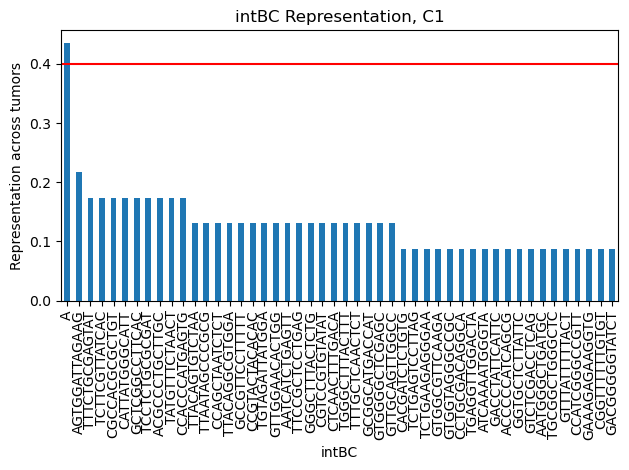

<Figure size 640x480 with 0 Axes>

In [24]:
clone = 'C1'
consensus_filter_bound = 0.4

props = es_rep_dfs[clone].copy()
props[props >= 0.1] = 1
props[props < 0.1] = 0

props2 = props.apply(lambda x: np.sum(x>0) / len(x)).to_frame().reset_index()
props2.columns = ['intBC', 'prop']
props2 = props2.loc[props2['prop'] > 0]

props2.index = props2.intBC
props2 = props2.sort_values(by = 'prop', ascending=False)

ibcs = props2[props2['prop'] > consensus_filter_bound].index  

plt.close()
props2[props2['prop'] > 0.05]['prop'].plot(kind = 'bar')
plt.axhline(y = consensus_filter_bound, color='red')
plt.ylabel('Representation across tumors')
plt.title('intBC Representation, ' + clone)
plt.tight_layout()
plt.show()
plt.savefig(script_dir +"/Figure/Figure1_S1/intBCRepresentation.png")

## Figures with filtered allele table

The plots below are made with a completely filtered allele table - after filtering out "normal" cells with few cut intBCs and subsetting intBCs to only those identified as consensus intBCs.

In [26]:
allele_table_final = pd.read_csv(f"{data_directory}/AP.alleleTable.unfiltered.txt2", sep='\t', converters={"Cell_Clone": str})

In [27]:
at_piv = pd.pivot_table(allele_table_final, index="cellBC", columns="intBC", values="UMI", aggfunc="sum")
at_piv.fillna(value = 0, inplace=True)
at_piv[at_piv > 0] = 1

es_rep_dfs = {}

for esc in tqdm_notebook(es_clones):
    
    if type(esc) != str:
        continue
    
    tumors = allele_table_final.loc[allele_table_final['Cell_Clone'] == esc, 'Tumor'].unique()
    tumor_dict = {}
    
    for tumor in tumors:
    
        cells = allele_table_final.loc[allele_table_final['Tumor'] == tumor, 'cellBC'].unique()
        tumor_piv = at_piv.loc[cells]
        
        if tumor_piv.shape[0] == 0:
            continue
            
        tumor_piv = tumor_piv.loc[:, tumor_piv.sum(axis=0) > 0]
            
        props = tumor_piv.apply(lambda x: np.sum(x>0) / len(x)).to_frame().reset_index()
        props.columns = ['intBC', 'prop']

        props = props.sort_values(by = 'prop', ascending=False)
        props = props[(props['intBC'] != 'NC')]

        props.index = props.intBC

        tumor_dict[tumor] = props['prop'].to_dict()
    
    if len(tumor_dict) > 0:
        tumor_df = pd.DataFrame.from_dict(tumor_dict, orient='index')
        tumor_df.fillna(value = 0, inplace=True)
        es_rep_dfs[esc] = tumor_df

/home/yanzeqin/miniconda3/envs/KP/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/2 [00:00<?, ?it/s]

### Figure 1D: intBC expression

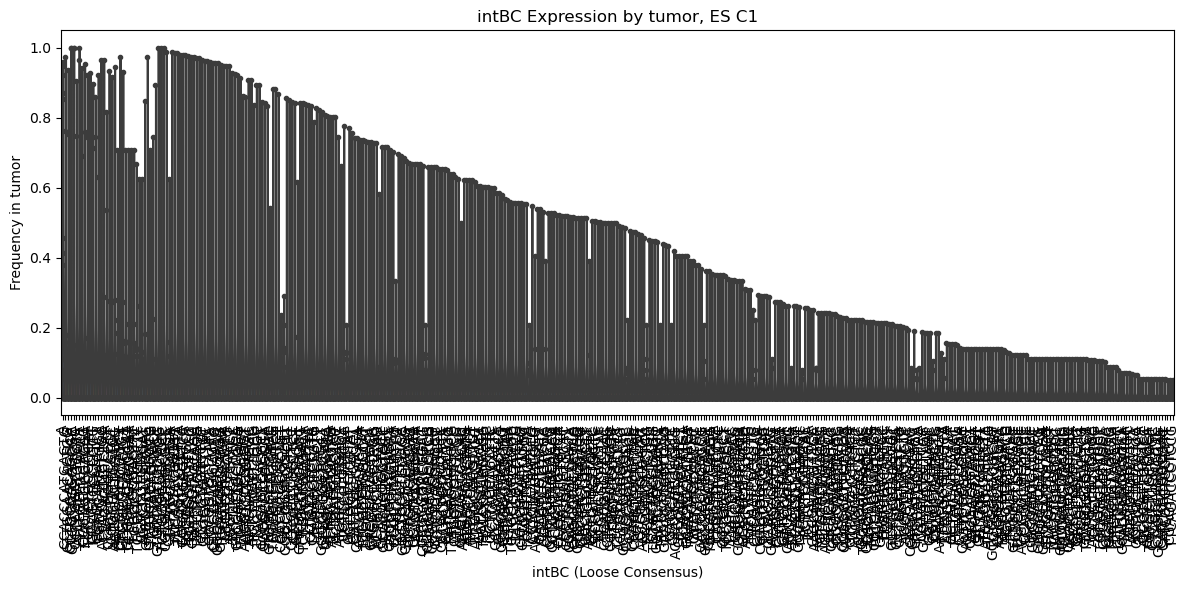

In [28]:
clone = 'C1'
ibcs = allele_table_final.loc[allele_table_final['Cell_Clone'] == clone, 'intBC'].unique()
ibcs = es_rep_dfs[clone][ibcs].mean(axis=0).sort_values(ascending=False).index.values

melted = pd.melt(es_rep_dfs[clone][ibcs])
h = plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="variable", y="value",
            data=melted, palette="muted", inner='point', cut=0, scale='count')
plt.xticks(rotation = 90)
plt.xlabel('intBC (Loose Consensus)')
plt.ylabel('Frequency in tumor')
plt.title('intBC Expression by tumor, ES ' +  clone)

plt.tight_layout()
plt.savefig(script_dir +"/Figure/Figure1_S1/intBcExpression.png")

### Figure S1G: intBC / cellBC pivot

In [29]:
clone_sizes = allele_table_final.groupby('Cell_Clone').agg({'cellBC': 'nunique'}).sort_values(by = 'cellBC')

# order tumors by ES clone ident
cell_ordering = []
es_annotation = []
es_to_intbcs = {}
for es in tqdm_notebook(clone_sizes.index):
    all_tumors = allele_table_final.loc[allele_table_final['Cell_Clone'] == es, 'Tumor'].unique()
    
    intBCs = allele_table_final.loc[allele_table_final['Cell_Clone'] == es, 'intBC'].value_counts().sort_values(ascending=False).index
    es_to_intbcs[es] = intBCs
    
    tumors = []
    for tumor in all_tumors:
        if tumor in tumor_list['Tumor'].tolist():
            tumors.append(tumor)

    for tumor in tumors:
        cells = allele_table_final.loc[allele_table_final['Tumor'] == tumor, 'cellBC'].unique()
        cell_ordering += list(cells)
        es_annotation += [es]*len(cells)

at_piv = pd.pivot_table(allele_table_final, columns='intBC', index='cellBC', values='UMI')
at_piv[at_piv > 0] = 1

at_piv = at_piv.loc[cell_ordering]

/home/yanzeqin/miniconda3/envs/KP/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/2 [00:00<?, ?it/s]

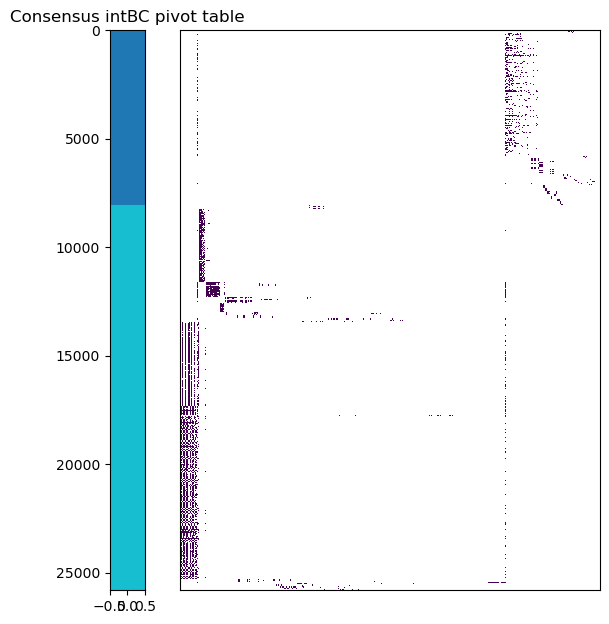

<Figure size 640x480 with 0 Axes>

In [30]:
all_consensus_ibcs = []
for es_clone in clone_sizes.index[::-1]:
    if es_clone in es_annotation:
        all_consensus_ibcs += list(es_to_intbcs[es_clone])

colors = list(plt.get_cmap('tab10').colors)
module_colors = {j: colors[(i-1) % len(colors)] for i, j in zip(range(len(np.unique(es_annotation))), np.unique(es_annotation))}

row_colors = pd.Series([module_colors[i] for i in es_annotation], index = at_piv.index)
cbar_mat = np.zeros((len(row_colors), 1, 3))
for r in range(len(row_colors)):
    cbar_mat[r, 0, :] = row_colors.iloc[r][0], row_colors.iloc[r][1], row_colors.iloc[r][2]

h2 = plt.figure(2,figsize=(7,7))
axmat2 = h2.add_axes([0.3,0.1,0.6,0.8])
im2 = axmat2.matshow(at_piv[all_consensus_ibcs], aspect='auto', origin='upper')
axmat2.set_yticks([])
axmat2.set_xticks([])

cbar = h2.add_axes([0.2, 0.1, 0.05, 0.8])
im3 = cbar.imshow(cbar_mat, aspect='auto', origin='upper', interpolation="none")

plt.title('Consensus intBC pivot table')
plt.show()
plt.savefig(script_dir +"/Figure/Figure1_S1/ConsensusintBC.png")

### Figure S1H: Tumor Quality-Control

In [31]:
tumor_stats = {}
tum_errors = []
numerr = 0

for tumor, tum_at in allele_table_final.groupby('Tumor'):
    print(tumor)
    clone = meta.loc[meta['Tumor'] == tumor, 'Cell_Clone'].iloc[0]

    tumor_at = allele_table_final[allele_table_final['Tumor'] == tumor].copy()
    tumor_at['lineageGrp'] = tumor_at['Tumor'].copy()
    lg = lg_util.collectAlleles(tumor_at, thresh=0.2)[0]

    # drop normal cells from lg
    n_cs = len(lg['intBC'].unique())*3
    #filt = lg.apply(lambda x: not meta.loc[x.cellBC, 'is_normal'], axis=1)
    #lg = lg.loc[filt]
    
    try:
        cm, priors, state2indel = util.alleletable_to_character_matrix(lg, write=False, allele_rep_thresh = 0.98)
    except:
        cm, priors, state2indel = util.alleletable_to_character_matrix(lg, write=False, allele_rep_thresh = 1.0)
    
    number_dropped_intbcs = (n_cs - cm.shape[1]) 
    pu = cm.apply(lambda x: percent_uncut(x.values), axis=1)

    cmf = cm[pu < 0.9]

    
    print(cmf.shape[0])
    if cmf.shape[0] == 0:
        continue

    puniq = cmf.drop_duplicates().shape[0] / cmf.shape[0]
    
    number_dropped_intbcs
    tumor_stats[tumor] = (puniq, compute_perc_indels(cmf), number_dropped_intbcs, 1.0 - (number_dropped_intbcs / n_cs), cmf.shape[0])

CTR_MGH_0


100%|██████████| 1/1 [00:00<00:00, 129.44it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CTTCTGTCCTGCA_r3', 'CCCGAACATTTCC_r3', 'TCTCCTAATTGAA_r3', 'CATGGTTGAGCAT_r1', 'CATGGTTGAGCAT_r3', 'ACAGCGCCTGTAT_r3', 'ACAGGGTATCAGT_r3', 'ACGCTCTCTGGAC_r2', 'ACGCTCTCTGGAC_r3', 'CGTGTGGCGAGCA_r1', 'TGTGTCGCATCTG_r2', 'TGTGTCGCATCTG_r3', 'GGCGAATTTAATC_r1', 'GGCGAATTTAATC_r3', 'TATGACGGTAGCG_r1', 'TATGACGGTAGCG_r2', 'TCTGTCTATTAAC_r1', 'TCTGTCTATTAAC_r2', 'TCTGTCTATTAAC_r3', 'GGCCAATGGATGA_r1']


Processing characters: 100%|██████████| 43/43 [00:00<00:00, 24642.04it/s]


133
CTR_MGH_1


100%|██████████| 1/1 [00:00<00:00, 78.27it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GAGTGGATATGGG_r1', 'GAGTGGATATGGG_r2', 'GAGTGGATATGGG_r3', 'TCTGAGTCCTTAG_r1', 'TCTGAGTCCTTAG_r2', 'TATGCCATGGCGA_r2', 'TATGCCATGGCGA_r3']


Processing characters: 100%|██████████| 14/14 [00:00<00:00, 566.80it/s]


3312
CTR_MGH_2


100%|██████████| 1/1 [00:00<00:00, 71.02it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AACGTTCCGGGGT_r1', 'AACGTTCCGGGGT_r2', 'AACGTTCCGGGGT_r3', 'ACTTATTCGCACC_r2', 'ACTTATTCGCACC_r3', 'AGTGCGCCTTCTT_r1', 'AGTGCGCCTTCTT_r2', 'AGTGCGCCTTCTT_r3', 'TTAGTCACGCGGT_r1', 'TTAGTCACGCGGT_r2', 'TTAGTCACGCGGT_r3', 'TCTGAGCGGGACA_r2', 'TCTGAGCGGGACA_r3', 'CTACTACCTAGTT_r1', 'CATGAAGTCCATC_r1', 'TCCGATTCCTCTT_r2', 'TCCGATTCCTCTT_r3', 'ATATTTCCCACTT_r1', 'GAAGTGTCACGCT_r1', 'GAAGTGTCACGCT_r3', 'GCAGCTCTGGATC_r2', 'GTTGTGGCTCTGA_r3', 'GCCGCCCTCCTCC_r1', 'GCCGCCCTCCTCC_r2', 'GCCGCCCTCCTCC_r3', 'CATGATGCACTTT_r1', 'CATGATGCACTTT_r2', 'CATGATGCACTTT_r3', 'CTCGACCCGCATA_r3']


Processing characters: 100%|██████████| 31/31 [00:00<00:00, 3577.38it/s]


603
CTR_MGH_3


100%|██████████| 1/1 [00:00<00:00, 76.63it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CTAGTCCTTAGTA_r1', 'CTAGTCCTTAGTA_r3', 'CGTGGTGCGTTAC_r1', 'CGTGGTGCGTTAC_r3', 'CCCGTGTGTGTCA_r3', 'CGGTGGGCGAATA_r3', 'CAGTGATACACTG_r1', 'CCCGTCCTTGTTC_r1', 'CCCGTCCTTGTTC_r3', 'GAAAATCGGCCAG_r1', 'GAAAATCGGCCAG_r2', 'GAAAATCGGCCAG_r3', 'AATCAGTTTGTTT_r1', 'ACACTTTTCGGCA_r1', 'ACCGTATGCGCGG_r2', 'ACCGTATGCGCGG_r3', 'GACCTCTGGTCTC_r1', 'GACCTCTGGTCTC_r3', 'CTCCATTATGACC_r1', 'CTCGATGTAATAT_r1', 'CTTGTTCTTGCTC_r1', 'CTTGTTCTTGCTC_r3', 'ATCGATTGGGCCC_r1', 'GAGCCCATTAGCA_r1', 'GAGCCCATTAGCA_r3', 'GCCTTGGTTACTT_r2', 'GCCTTGGTTACTT_r3', 'GCGGACCGGGCTC_r1', 'GCGGACCGGGCTC_r3', 'TCCGCTTCGTTTC_r1', 'TCTGTGACATGAA_r1', 'TCTGTGACATGAA_r3', 'TTCAAAGTTCTGG_r3', 'TTCGCGGAGTTCA_r1', 'TTCGGCGTGCCCT_r1', 'TTCGGCGTGCCCT_r3', 'AGTGTAGGGGATG_r1', 'AGTGTAGGGGATG_r3', 'TTCGTATTCGATA_r1', 'TTCGTATTCGATA_r2', 'TTTCGGTAGGTTC_r1', 'TTTCGGTAGGTTC_r2', 'TTTCGGTAGGTTC_r3', 'TGCGTGACCACGG_r1', 'TGCGTGACCACGG_r2', 'GACGCGGGGAAAT_r1', 'GA

Processing characters: 100%|██████████| 43/43 [00:00<00:00, 14689.29it/s]


200
CTR_MGH_4


100%|██████████| 1/1 [00:00<00:00, 190.22it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AGGTTACTCAACT_r2', 'AGGTTACTCAACT_r3', 'CCTAGTACTCCTC_r2', 'CCTAGTACTCCTC_r3', 'GGGAATCAGATTC_r1', 'GGGAATCAGATTC_r2', 'GGGAATCAGATTC_r3']


Processing characters: 100%|██████████| 11/11 [00:00<00:00, 3820.58it/s]


420
CTR_MGH_5


100%|██████████| 1/1 [00:00<00:00, 168.95it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTCCTGCACTAGG_r2', 'GTCCTGCACTAGG_r3', 'TTCGAGGAGTGCT_r1', 'TTCGAGGAGTGCT_r2', 'TTCGAGGAGTGCT_r3', 'CGTCAGGAGTCGA_r1', 'CGTCAGGAGTCGA_r2', 'CGTCAGGAGTCGA_r3', 'CAAAGTCGACTCT_r1', 'CAAAGTCGACTCT_r2', 'CAAAGTCGACTCT_r3', 'TGAGTACTTATCC_r1', 'TGAGTACTTATCC_r2', 'TGAGTACTTATCC_r3', 'TTTGCGTAGCTGC_r1', 'TTTGCGTAGCTGC_r2', 'TTTGCGTAGCTGC_r3', 'TTGTCGTCATCAC_r1', 'TTGTCGTCATCAC_r2', 'TTGTCGTCATCAC_r3']


Processing characters: 100%|██████████| 16/16 [00:00<00:00, 16404.02it/s]


119
CTR_MGH_6


100%|██████████| 1/1 [00:00<00:00, 196.41it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTGGCTTGGCCAT_r1', 'TTGGCTTGGCCAT_r2', 'GGGCGGATGGCGT_r1', 'GGGCGGATGGCGT_r2', 'GGGCGGATGGCGT_r3', 'CTGGGAAACAATG_r1', 'CTGGGAAACAATG_r2', 'CTGGGAAACAATG_r3', 'GTGATTGACCGGG_r1', 'GTGATTGACCGGG_r2', 'GTGATTGACCGGG_r3', 'TATGCGGCGTTCA_r2', 'TATGCGGCGTTCA_r3', 'CCTATTCCGGTTA_r1', 'CCTATTCCGGTTA_r2', 'CCTATTCCGGTTA_r3', 'CGCGCGGACGGCT_r1']


Processing characters: 100%|██████████| 7/7 [00:00<00:00, 11896.32it/s]

139


CTR_MGH_7


100%|██████████| 1/1 [00:00<00:00, 134.23it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GCCTCCGTCTTTG_r1', 'GCCTCCGTCTTTG_r3', 'CTCCTAATACGTG_r3', 'CGCGTATAGTCGC_r1', 'CGCGTATAGTCGC_r3', 'CTGGGTTGCATCT_r1', 'CTAATAACATTCT_r3', 'GCTCAGCCCTACA_r1', 'GCTCAGCCCTACA_r2', 'GCTCAGCCCTACA_r3', 'CTTGCATCGCTCT_r3', 'AGGTGTGGTACGT_r1', 'AGGTGTGGTACGT_r3', 'ATAGTTATGATGT_r3', 'CAGGTTAATCCAT_r1', 'TTGGTGTGATATA_r3', 'TATAGACCGCCGT_r2', 'TGGCTTGAAGTGT_r1', 'CACGTGCATGGTG_r1', 'TCCGTGGACGCGT_r1', 'TCCGTGGACGCGT_r3', 'GTTTGGTGTGCAG_r1', 'ATGAGGTTACTAT_r1', 'CTAGACTACCTGG_r1', 'CTAGACTACCTGG_r2', 'CAAACTGGGTTGC_r1', 'CAAACTGGGTTGC_r3', 'CCTGGCAGCAACA_r1', 'GTCTGCTTCGACG_r1', 'GTCTGCTTCGACG_r2', 'TCGGGTGTTTAAT_r1']


Processing characters: 100%|██████████| 56/56 [00:00<00:00, 48160.96it/s]


21
CTR_MGH_8


100%|██████████| 1/1 [00:00<00:00, 137.00it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CGTGACCTGTGCC_r1', 'CGTGACCTGTGCC_r3', 'ATTGGCAACTAGG_r1', 'ATTGGCAACTAGG_r2', 'CTACTCAGGAGCC_r1', 'CTACTCAGGAGCC_r2', 'CTACTCAGGAGCC_r3', 'GCCGGTACGCAAG_r1', 'GCCGGTACGCAAG_r2', 'GCCGGTACGCAAG_r3', 'CTGGTGCTTTTCC_r2', 'CTGGTGCTTTTCC_r3', 'GCACGCTGGCTAG_r1', 'GCACGCTGGCTAG_r2', 'TCTCTATCGATTT_r2', 'TGGGGCAGCCCCG_r2', 'TGGGGCAGCCCCG_r3', 'TTAGTTCCTTGTC_r1', 'TTAGTTCCTTGTC_r2', 'TTAGTTCCTTGTC_r3', 'TTGGTTAGTATGC_r2', 'TTGGTTAGTATGC_r3', 'TTGTCTGCGTCAT_r2', 'TTGTCTGCGTCAT_r3', 'CATGCGGTGCGGC_r1', 'CATGCGGTGCGGC_r3', 'GATGCGTAGCTAT_r1', 'GATGCGTAGCTAT_r3', 'GCATAGCAAGGGT_r1', 'GAGGTATCCTTAC_r1', 'GAGGTATCCTTAC_r2', 'GAGGTATCCTTAC_r3']


Processing characters: 100%|██████████| 19/19 [00:00<00:00, 51984.20it/s]


38
CTR_MGH_9


100%|██████████| 1/1 [00:00<00:00, 219.42it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GGCCACACGGAAA_r1', 'GGCCACACGGAAA_r2', 'GGCCACACGGAAA_r3', 'GCTGTCAATCCCT_r1', 'ACACTGTTGTTTA_r1', 'ACACTGTTGTTTA_r3']


Processing characters: 100%|██████████| 18/18 [00:00<00:00, 62653.50it/s]


23
CTR_RT_0


100%|██████████| 1/1 [00:00<00:00, 203.08it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CAGTGCCGTGGGC_r1', 'CAGTGCCGTGGGC_r2', 'CACGATACCAAGA_r1', 'CACGATACCAAGA_r3', 'TGTCCGCGCGCCT_r3', 'TGGGTGCGGCCGA_r2', 'TGGGTGCGGCCGA_r3', 'AGTGCTCCAATGT_r3', 'ATTGCTTCTAATG_r1']


Processing characters: 100%|██████████| 15/15 [00:00<00:00, 32853.56it/s]


38
CTR_RT_1


100%|██████████| 1/1 [00:00<00:00, 43.20it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CATCCCTCTTGAA_r1', 'CATCCCTCTTGAA_r2', 'CATCCCTCTTGAA_r3', 'CCGGTGGCTCTTC_r1', 'CCGGTGGCTCTTC_r2', 'CCGGTGGCTCTTC_r3', 'CGTGTCAGGTCCG_r1', 'CGTGTCAGGTCCG_r2', 'CGTGTCAGGTCCG_r3', 'TCCGAGTTCGCTC_r1', 'TCCGAGTTCGCTC_r2', 'TCCGAGTTCGCTC_r3', 'TCTAATGTTTCTT_r1', 'TCTAATGTTTCTT_r2', 'TCTAATGTTTCTT_r3', 'TGTGCCGCACTCC_r1']


Processing characters: 100%|██████████| 11/11 [00:00<00:00, 819.97it/s]


2874
GEM_RT_0


100%|██████████| 1/1 [00:00<00:00, 214.27it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TACGCTCCCACCT_r1', 'TACGCTCCCACCT_r2', 'TACGCTCCCACCT_r3', 'GTCGACGAGTTAG_r1', 'GTCGACGAGTTAG_r2', 'GTCGACGAGTTAG_r3', 'TAGAGAGGGGGTG_r1', 'TAGAGAGGGGGTG_r2', 'TAGAGAGGGGGTG_r3', 'AAGCAGTTGCGCT_r1', 'AAGCAGTTGCGCT_r2', 'AAGCAGTTGCGCT_r3', 'AACGTTGAGCGTT_r1', 'AACGTTGAGCGTT_r2', 'AACGTTGAGCGTT_r3', 'TCTGTCCCGTTTT_r1', 'TCTGTCCCGTTTT_r2', 'TCTGTCCCGTTTT_r3', 'GCGGTTGGTCGGG_r1', 'GCGGTTGGTCGGG_r2', 'GCGGTTGGTCGGG_r3', 'TTCGTAGGGCCTC_r1', 'TTCGTAGGGCCTC_r2', 'TTCGTAGGGCCTC_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 24/24 [00:00<00:00, 52483.47it/s]


0
GEM_RT_1


100%|██████████| 1/1 [00:00<00:00, 134.77it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AGTGGGAGGAAGG_r3', 'ATTGGACATTTGG_r3', 'GACTAGTTAAGTT_r2', 'GACTAGTTAAGTT_r3', 'TGTAGGTGGTACG_r2', 'TGTAGGTGGTACG_r3', 'TCTCGTACGCTCT_r2', 'TCTCGTACGCTCT_r3', 'CGAGTTGTTCCGC_r1', 'CGAGTTGTTCCGC_r2', 'CGAGTTGTTCCGC_r3', 'CACAAGGAGAATC_r1', 'CACAAGGAGAATC_r2', 'CACAAGGAGAATC_r3', 'GGTGTTAACTATC_r1', 'GGTGTTAACTATC_r2', 'GGTGTTAACTATC_r3', 'GTGGGTGTACTCA_r1', 'GTGGGTGTACTCA_r2', 'GTGGGTGTACTCA_r3', 'CTCGGTCCGGCTT_r1', 'CTCGGTCCGGCTT_r2', 'CTCGGTCCGGCTT_r3', 'TCTACAGTGGTCT_r1', 'TCTACAGTGGTCT_r2', 'TCTACAGTGGTCT_r3']


Processing characters: 100%|██████████| 10/10 [00:00<00:00, 6442.86it/s]


402
GEM_RT_10


100%|██████████| 1/1 [00:00<00:00, 224.28it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TCACAATTGGAGT_r1', 'TCACAATTGGAGT_r2', 'TCACAATTGGAGT_r3', 'ATCATTGGTGCTC_r1', 'ATCATTGGTGCTC_r2', 'ATCATTGGTGCTC_r3', 'ACTATCGTACCTT_r1', 'ACTATCGTACCTT_r2', 'ACTATCGTACCTT_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 9/9 [00:00<00:00, 44620.26it/s]


0
GEM_RT_11


100%|██████████| 1/1 [00:00<00:00, 218.39it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ATACTGAAGATGG_r1', 'ATACTGAAGATGG_r2', 'ATACTGAAGATGG_r3', 'ATAGATACCGTTG_r1', 'ATAGATACCGTTG_r2', 'ATAGATACCGTTG_r3', 'TCGGCGCATGCTC_r1', 'TCGGCGCATGCTC_r2', 'TCGGCGCATGCTC_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 9/9 [00:00<00:00, 46204.08it/s]


0
GEM_RT_12


100%|██████████| 1/1 [00:00<00:00, 248.63it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 9/9 [00:00<00:00, 29911.84it/s]


66
GEM_RT_13


100%|██████████| 1/1 [00:00<00:00, 271.18it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TCTGGCTCGACTT_r1', 'TCTGGCTCGACTT_r2']


Processing characters: 100%|██████████| 4/4 [00:00<00:00, 30283.78it/s]


36
GEM_RT_14


100%|██████████| 1/1 [00:00<00:00, 216.26it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CGCGGCATACATC_r1', 'CGCGGCATACATC_r2', 'CGCGGCATACATC_r3', 'CGAGCCGATTGAC_r1', 'CGAGCCGATTGAC_r2', 'CGAGCCGATTGAC_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 6/6 [00:00<00:00, 43389.35it/s]


0
GEM_RT_15


100%|██████████| 1/1 [00:00<00:00, 119.61it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TACCTCAAAGTTT_r1', 'TACCTCAAAGTTT_r2', 'TACCTCAAAGTTT_r3', 'AGGTAGCGTCCCT_r1', 'AGGTAGCGTCCCT_r2', 'AGGTAGCGTCCCT_r3', 'TGTGGTCTTACTT_r1', 'TGTGGTCTTACTT_r2', 'TGTGGTCTTACTT_r3', 'ACTCTATTTCCTA_r1', 'ACTCTATTTCCTA_r2', 'ACTCTATTTCCTA_r3', 'CTCGTCACGTTCT_r1']


Processing characters: 100%|██████████| 2/2 [00:00<00:00, 26462.49it/s]


15
GEM_RT_16


100%|██████████| 1/1 [00:00<00:00, 229.86it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AATGTTTCATCAT_r1', 'AATGTTTCATCAT_r2', 'AATGTTTCATCAT_r3', 'GCCGTTCCCCCGT_r1', 'GCCGTTCCCCCGT_r2', 'GCCGTTCCCCCGT_r3', 'CCTCAAGACCCTC_r1', 'CCTCAAGACCCTC_r2', 'CCTCAAGACCCTC_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 9/9 [00:00<00:00, 59729.01it/s]


0
GEM_RT_17


100%|██████████| 1/1 [00:00<00:00, 286.65it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TGGGTGTCCCTTA_r2']


Processing characters: 100%|██████████| 2/2 [00:00<00:00, 23563.51it/s]


11
GEM_RT_18


100%|██████████| 1/1 [00:00<00:00, 255.63it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCCTGGCTCAAT_r1', 'TTCCTGGCTCAAT_r3']


Processing characters: 100%|██████████| 1/1 [00:00<00:00, 14768.68it/s]


4
GEM_RT_19


100%|██████████| 1/1 [00:00<00:00, 269.59it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TCTGTCGCGTTTC_r1', 'TCTGTCGCGTTTC_r2', 'TCTGTCGCGTTTC_r3']


Processing characters: 100%|██████████| 3/3 [00:00<00:00, 26829.24it/s]


25
GEM_RT_2


100%|██████████| 1/1 [00:00<00:00, 247.60it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CAAGCTCTGCCAA_r1', 'CAAGCTCTGCCAA_r2', 'CAAGCTCTGCCAA_r3', 'CGGGCTTAATCTT_r1', 'CGGGCTTAATCTT_r2', 'CGGGCTTAATCTT_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 6/6 [00:00<00:00, 21272.89it/s]


0
GEM_RT_3


100%|██████████| 1/1 [00:00<00:00, 261.15it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTTGCTTAGACGG_r1', 'GTTGCTTAGACGG_r2', 'GTTGCTTAGACGG_r3', 'AGGACAAGCATAG_r1', 'AGGACAAGCATAG_r2', 'AGGACAAGCATAG_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 6/6 [00:00<00:00, 23410.07it/s]


0
GEM_RT_4


100%|██████████| 1/1 [00:00<00:00, 220.25it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ATTCACCTTAGTT_r1', 'ATTCACCTTAGTT_r2', 'ATTCACCTTAGTT_r3', 'CTGTTTTATGATT_r1', 'CTGTTTTATGATT_r2', 'CTGTTTTATGATT_r3', 'GACAATTTGCGCA_r1', 'GACAATTTGCGCA_r2', 'GACAATTTGCGCA_r3', 'TCTCCGGACACTT_r1', 'TCTCCGGACACTT_r2', 'TCTCCGGACACTT_r3', 'GGGCTTTGCTTTA_r1', 'GGGCTTTGCTTTA_r2', 'GGGCTTTGCTTTA_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 15/15 [00:00<00:00, 25954.85it/s]


0
GEM_RT_5


100%|██████████| 1/1 [00:00<00:00, 238.37it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AGAGGCTTGGTGC_r1', 'AGAGGCTTGGTGC_r2', 'AGAGGCTTGGTGC_r3', 'GGACAGCTGGGGG_r1', 'GGACAGCTGGGGG_r3', 'TAAAGGGTGGTCT_r1', 'TAAAGGGTGGTCT_r2', 'TAAAGGGTGGTCT_r3']


Processing characters: 100%|██████████| 1/1 [00:00<00:00, 8128.50it/s]


3
GEM_RT_6


100%|██████████| 1/1 [00:00<00:00, 266.59it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 6/6 [00:00<00:00, 18669.01it/s]

116
GEM_RT_7



100%|██████████| 1/1 [00:00<00:00, 231.49it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CCTACCGAGTGGT_r1', 'CCTACCGAGTGGT_r2', 'CCTACCGAGTGGT_r3', 'TTCTAGAATGTAA_r1', 'TTCTAGAATGTAA_r2', 'TTCTAGAATGTAA_r3', 'AGTATTTTCTGTC_r1', 'AGTATTTTCTGTC_r2', 'AGTATTTTCTGTC_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 9/9 [00:00<00:00, 32374.56it/s]


0
GEM_RT_8


100%|██████████| 1/1 [00:00<00:00, 241.16it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TGAGCAGCTAGCG_r1', 'TGAGCAGCTAGCG_r2', 'TGAGCAGCTAGCG_r3', 'GCTTTCCATCTAT_r1', 'GCTTTCCATCTAT_r2', 'GCTTTCCATCTAT_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 6/6 [00:00<00:00, 30066.70it/s]


0
GEM_RT_9


100%|██████████| 1/1 [00:00<00:00, 232.75it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTGTTTTCTTTC_r1', 'TTTGTTTTCTTTC_r2', 'TTTGTTTTCTTTC_r3', 'GGCAGTGGATAGG_r1', 'GGCAGTGGATAGG_r2', 'GGCAGTGGATAGG_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 6/6 [00:00<00:00, 34855.71it/s]

0
MI_MGH_0



100%|██████████| 1/1 [00:00<00:00, 103.76it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CCCAGTCTAGTCT_r1', 'CCCAGTCTAGTCT_r2', 'CCCAGTCTAGTCT_r3', 'ATGGTGGTGTATA_r1', 'TATGCCAACTTCT_r1', 'TATGCCAACTTCT_r2', 'TATGCCAACTTCT_r3', 'TCAGTGGATCCTC_r1', 'TTACCGGGGGGCG_r1', 'TTACCGGGGGGCG_r2', 'TTATCCAAGGCGG_r1', 'TTATCCAAGGCGG_r2', 'TTATCCAAGGCGG_r3', 'A_r3', 'AATGATCATTAGG_r3', 'ACCGGATATCATA_r2', 'ATGACTGACTATG_r2', 'ATGACTGACTATG_r3', 'GCCAAAAAAACTA_r1', 'GCCAAAAAAACTA_r2', 'GCCAAAAAAACTA_r3', 'GCCAAAAAAAACT_r1', 'GCCAAAAAAAACT_r2', 'GCCAAAAAAAACT_r3']


Processing characters: 100%|██████████| 15/15 [00:00<00:00, 44306.03it/s]


37
MI_MGH_1


100%|██████████| 1/1 [00:00<00:00, 15.42it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AATGGGCTGATGC_r1', 'AATGGGCTGATGC_r2', 'AATGGGCTGATGC_r3', 'ACGCCCTGCTTGC_r1', 'ACGCCCTGCTTGC_r2', 'ACGCCCTGCTTGC_r3', 'CCATCGGGCCGTT_r1', 'CCATCGGGCCGTT_r2', 'CCATCGGGCCGTT_r3', 'CGGTTTTTTGTGT_r1', 'CGGTTTTTTGTGT_r2', 'CGGTTTTTTGTGT_r3', 'GACGGGGGTATCT_r1', 'GACGGGGGTATCT_r2', 'GACGGGGGTATCT_r3', 'GTGGCGTTCAAGA_r1', 'GTGGCGTTCAAGA_r2', 'GTGGCGTTCAAGA_r3', 'TAAATACAGCGTG_r1', 'TAAATACAGCGTG_r2', 'TAAATACAGCGTG_r3', 'TGTAGATTATGGA_r1', 'TGTAGATTATGGA_r2', 'TGTAGATTATGGA_r3', 'GCTCGGCCTTCAC_r1', 'GTGGGGCTCGAGC_r1', 'GTGGGGCTCGAGC_r2', 'GTGGGGCTCGAGC_r3', 'GTTGGAACACTGG_r1', 'TATGTTTCTAACT_r1', 'TATGTTTCTAACT_r2', 'TCCTCTGCGCGAT_r1', 'TCCTCTGCGCGAT_r3', 'TTAATAGCCCGCG_r1', 'TTAATAGCCCGCG_r2', 'TTAATAGCCCGCG_r3', 'TTACAGGCGTGGA_r1', 'TTACAGGCGTGGA_r3', 'TTACAGTGTCTAA_r1', 'TTACAGTGTCTAA_r3', 'CCAGCTAATCTCT_r1', 'CCAGCTAATCTCT_r3', 'CCGTACTACACAC_r2', 'CCGTACTACACAC_r3', 'GCCGTTCCTTTTT_r1', 'GCCGTTCCTTTTT_r2', 'GC

Processing characters: 100%|██████████| 13/13 [00:00<00:00, 305.93it/s]


3071
MI_MGH_2


100%|██████████| 1/1 [00:00<00:00, 131.19it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTATCAATGATGA_r1', 'TTATCAATGATGA_r2', 'AGTGCTTTGGTAT_r2', 'AGTGCTTTGGTAT_r3', 'TTGTATTGATTAT_r2', 'TTGTATTGATTAT_r3', 'CGTCAGCATCCAA_r2', 'CGTCAGCATCCAA_r3', 'TTTGCGACTCTAT_r1', 'CTTGCCTGCTTTG_r3']


Processing characters: 100%|██████████| 29/29 [00:00<00:00, 14389.54it/s]


152
MI_MGH_3


100%|██████████| 1/1 [00:00<00:00, 177.11it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CCTGCGACAGGCA_r1', 'CCTGCGACAGGCA_r2', 'CCTGCGACAGGCA_r3', 'ATCAAAATGGGTA_r1', 'ATCAAAATGGGTA_r2', 'ATCAAAATGGGTA_r3', 'GTGGTAGGGCCGC_r1', 'GTGGTAGGGCCGC_r3']


Processing characters: 100%|██████████| 1/1 [00:00<00:00, 15768.06it/s]


5
Met_MGH_0


100%|██████████| 1/1 [00:00<00:00, 142.54it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AATCATCTGAGTT_r1', 'GACCTATTCATTC_r1', 'GACCTATTCATTC_r2', 'TCTTCGTTATCAC_r1', 'TCTTCGTTATCAC_r3', 'CGCCACGCGCTGT_r1', 'TGAGGTTGGACTA_r2', 'TTCCGCTCCTGAG_r1', 'TTCCGCTCCTGAG_r2', 'ACCGTATAACTCA_r1', 'CATTATGGGCATT_r2', 'CATTATGGGCATT_r3', 'GTTGCAGTTGGCC_r1', 'GTTGCAGTTGGCC_r2', 'GTTGCAGTTGGCC_r3', 'CGTCCGTGTATAT_r2', 'CGTCCGTGTATAT_r3', 'AGTGGATTAGAAG_r2', 'AGTGGATTAGAAG_r3', 'TCTGAAGAGGGAA_r2', 'TCTGAAGAGGGAA_r3', 'TGCGGCTGGGCTC_r1', 'TGCGGCTGGGCTC_r2', 'TGCGGCTGGGCTC_r3', 'TTTCTGCGAGTAT_r2', 'TTTCTGCGAGTAT_r3', 'TTTGCTCAACTCT_r2', 'GCGGCATGACCAT_r2', 'GCGGCATGACCAT_r3', 'TGGGCTTTACTTT_r1', 'GTCTCGACCTCAG_r2', 'GTCTCGACCTCAG_r3', 'GGGCTTTACTCTG_r1', 'GGGCTTTACTCTG_r2']


Processing characters: 100%|██████████| 32/32 [00:00<00:00, 103964.16it/s]

22
Met_MGH_1



100%|██████████| 1/1 [00:00<00:00, 39.94it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AGACTATCGAGAT_r1', 'AGACTATCGAGAT_r2', 'AGACTATCGAGAT_r3', 'CGGTTTTTTGTGT_r1', 'CGGTTTTTTGTGT_r2', 'CGGTTTTTTGTGT_r3', 'GACGGGGGTATCT_r1', 'GACGGGGGTATCT_r2', 'GACGGGGGTATCT_r3', 'GTGGCGTTCAAGA_r1', 'GTGGCGTTCAAGA_r2', 'GTGGCGTTCAAGA_r3', 'TGTAGATTATGGA_r1', 'TGTAGATTATGGA_r2', 'TGTAGATTATGGA_r3', 'TAAATACAGCGTG_r1', 'TAAATACAGCGTG_r2', 'TAAATACAGCGTG_r3', 'ACGCCCTGCTTGC_r1', 'ACGCCCTGCTTGC_r2', 'ACGCCCTGCTTGC_r3', 'CCATCGGGCCGTT_r1', 'CCATCGGGCCGTT_r2', 'CCATCGGGCCGTT_r3', 'A_r1', 'A_r2', 'A_r3', 'AATGGGCTGATGC_r1', 'AATGGGCTGATGC_r2', 'AATGGGCTGATGC_r3', 'ATGGCCTTTGAGT_r1', 'ATGGCCTTTGAGT_r2', 'ATGGCCTTTGAGT_r3', 'GTTACAAGTAGCT_r1', 'GTTACAAGTAGCT_r2', 'GTTACAAGTAGCT_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 36/36 [00:00<00:00, 681.35it/s]


2
Met_MGH_2


100%|██████████| 1/1 [00:00<00:00, 122.22it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GCTCGGCCTTCAC_r1', 'GCTCGGCCTTCAC_r2', 'GCTCGGCCTTCAC_r3', 'CCACCCATGAGTG_r3', 'CCAGCTAATCTCT_r1', 'CCAGCTAATCTCT_r3', 'CCGTACTACACAC_r1', 'CCGTACTACACAC_r2', 'CCGTACTACACAC_r3', 'GCCGTTCCTTTTT_r1', 'GCCGTTCCTTTTT_r2', 'GCCGTTCCTTTTT_r3', 'TTACAGGCGTGGA_r1', 'TTACAGGCGTGGA_r3', 'TTACAGTGTCTAA_r1', 'TTACAGTGTCTAA_r2', 'TTACAGTGTCTAA_r3', 'TTAATAGCCCGCG_r1', 'TTAATAGCCCGCG_r2', 'TTAATAGCCCGCG_r3', 'TCCTCTGCGCGAT_r1', 'TCCTCTGCGCGAT_r2', 'TCCTCTGCGCGAT_r3', 'TATGTTTCTAACT_r1', 'GTTGGAACACTGG_r1', 'A_r1']


Processing characters: 100%|██████████| 10/10 [00:00<00:00, 8292.42it/s]


346
Met_MGH_3


100%|██████████| 1/1 [00:00<00:00, 252.49it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CCTGCGACAGGCA_r1', 'CCTGCGACAGGCA_r2', 'CCTGCGACAGGCA_r3', 'GTGGTAGGGCCGC_r1', 'GTGGTAGGGCCGC_r3', 'ATCAAAATGGGTA_r1', 'ATCAAAATGGGTA_r2', 'ATCAAAATGGGTA_r3']


Processing characters: 100%|██████████| 1/1 [00:00<00:00, 19599.55it/s]


2
NMI_MGH_0


100%|██████████| 1/1 [00:00<00:00, 115.42it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CACGATCTCTGTG_r1', 'CACGATCTCTGTG_r2', 'AAACCAGTTTATT_r1', 'AAACCAGTTTATT_r2', 'CCTGTGCACGATA_r1', 'CCTGTGCACGATA_r2', 'CCTGTGCACGATA_r3', 'CTACCAGTGCGGC_r2', 'CTACCAGTGCGGC_r3', 'GGACGAATTTTAG_r1', 'TAAGTAAAGGAAA_r1', 'TAAGTAAAGGAAA_r2', 'TAAGTAAAGGAAA_r3', 'TATGGGTATTCCG_r3', 'TTCGCATTTCCTC_r1', 'TTCGCATTTCCTC_r2', 'TTCGCATTTCCTC_r3', 'TGTGCTGGCAGGG_r3', 'CACCATATGTTAG_r3', 'AGTGGATTAGAAG_r1', 'AGTGGATTAGAAG_r2', 'AGTGGATTAGAAG_r3', 'AAGGCATTGTGCA_r1', 'AAGGCATTGTGCA_r2', 'AAGGCATTGTGCA_r3', 'AAGGCCAGTCTCT_r1', 'AAGGCCAGTCTCT_r3', 'CAAGATACCCTTC_r1', 'CAAGATACCCTTC_r2', 'CAAGATACCCTTC_r3', 'GTTAACAGTGACA_r1', 'GTTAACAGTGACA_r2', 'GTTAACAGTGACA_r3', 'TGTGTCCCTCTTT_r1']


Processing characters: 100%|██████████| 17/17 [00:00<00:00, 155006.89it/s]


8
NMI_MGH_2


100%|██████████| 1/1 [00:00<00:00, 120.50it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AAAAAATGGTGCG_r1', 'AAAAAATGGTGCG_r2', 'CCATTCGGGGGCA_r2', 'GACGTTTCGCGCA_r3', 'GCGGAGTGGTGTC_r2', 'GCGGAGTGGTGTC_r3', 'GCTGGCCTTATAT_r2', 'GCTGGCCTTATAT_r3', 'GTGACCTGCAGGG_r2', 'TCAGCCTATATGA_r1', 'TGGGCCTACAAGT_r3', 'TTAGGTTCATCGC_r2', 'TTAGGTTCATCGC_r3', 'A_r3', 'ACCGGTAAGGCGA_r1', 'ACCGGTAAGGCGA_r2', 'ACCGGTAAGGCGA_r3', 'TTTGTGGCGAGTG_r2', 'TTTGTGGCGAGTG_r3', 'TTGCTAGATACGG_r1', 'TTGCTAGATACGG_r2', 'TTGCTAGATACGG_r3', 'GCTCATAATGTCT_r1', 'GCTCATAATGTCT_r3', 'CCAGAAGTGCCAG_r1', 'CCAGAAGTGCCAG_r2', 'CCAGAAGTGCCAG_r3', 'GTTCTAAGGTGAC_r1', 'GTTCTAAGGTGAC_r2', 'GTTCTAAGGTGAC_r3', 'GTTGTCTAAATGT_r1', 'GTTGTCTAAATGT_r2', 'GTTGTCTAAATGT_r3', 'ACTTTCCTATTAT_r1', 'ACTTTCCTATTAT_r2', 'ACTTTCCTATTAT_r3', 'TCAGTTTTTTCTC_r1', 'TCAGTTTTTTCTC_r2', 'TCAGTTTTTTCTC_r3', 'TCGACGGGAACGC_r1', 'TCGACGGGAACGC_r2', 'TCGACGGGAACGC_r3']


Processing characters: 100%|██████████| 27/27 [00:00<00:00, 32920.41it/s]


66
NMI_MGH_3


100%|██████████| 1/1 [00:00<00:00, 165.22it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CGTGATTGGCGCC_r2', 'GCCTCTCGGCGGC_r1', 'GCCTCTCGGCGGC_r2', 'GCCTCTCGGCGGC_r3', 'GTGCGTGATTTGT_r1', 'GTGCGTGATTTGT_r3', 'TATTTGGCTTTGC_r1', 'TATTTGGCTTTGC_r2', 'TATTTGGCTTTGC_r3', 'CATTCGTTAGCCT_r2', 'GCCTGGACTGCTT_r1', 'GCCTGGACTGCTT_r3']


Processing characters: 100%|██████████| 9/9 [00:00<00:00, 23741.34it/s]


81
NMI_MGH_4


100%|██████████| 1/1 [00:00<00:00, 114.60it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CCCGGTGTTAATA_r2', 'TTAGAACTCCGGC_r3', 'GCGGCATGACCAT_r1', 'GCGGCATGACCAT_r2', 'GCGGCATGACCAT_r3']


Processing characters: 100%|██████████| 37/37 [00:00<00:00, 25205.34it/s]

76


NMI_MGH_5


100%|██████████| 1/1 [00:00<00:00, 140.83it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TCCAATCCGAATT_r1', 'TCCAATCCGAATT_r2', 'CTCGTTTGGTTCT_r1', 'CTCGTTTGGTTCT_r3', 'GTACTCAGGCGAA_r2', 'GTACTCAGGCGAA_r3', 'ATTATTACAGTAA_r1', 'ATTATTACAGTAA_r2', 'ATTATTACAGTAA_r3']


Processing characters: 100%|██████████| 9/9 [00:00<00:00, 34442.28it/s]


50
NMI_MGH_6


100%|██████████| 1/1 [00:00<00:00, 134.56it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TGCGGCTGGGCTC_r1', 'TGCGGCTGGGCTC_r2', 'TGCGGCTGGGCTC_r3', 'TGTAGGATTTTCG_r1', 'TGTAGGATTTTCG_r2', 'TGTAGGATTTTCG_r3', 'TCTGCGGAGCCCC_r2', 'TCTGCGGAGCCCC_r3', 'TCCGTGTCCACAA_r1', 'TCCGTGTCCACAA_r2', 'TCCGTGTCCACAA_r3', 'TTTCTGCGAGTAT_r2', 'TTTCTGCGAGTAT_r3', 'CGAAGGTAATAAC_r1', 'CGAAGGTAATAAC_r2', 'CGAAGGTAATAAC_r3', 'AGTATTTCTCCTG_r1', 'AGTATTTCTCCTG_r2', 'AGTATTTCTCCTG_r3', 'AACGATTTGATCT_r1', 'AACGATTTGATCT_r3', 'A_r1', 'A_r2', 'A_r3', 'GTCTCGTACTATT_r1', 'TCTGAAGAGGGAA_r2', 'TCTGAAGAGGGAA_r3', 'CATTATGGGCATT_r2', 'CATTATGGGCATT_r3']


Processing characters: 100%|██████████| 10/10 [00:00<00:00, 53159.75it/s]

16

In [32]:
tumor_stats

{'CTR_MGH_0': (0.6616541353383458,
  0.4214328717639976,
  20,
  0.6825396825396826,
  133),
 'CTR_MGH_1': (0.5960144927536232,
  0.7157277882797732,
  7,
  0.6666666666666667,
  3312),
 'CTR_MGH_2': (0.8971807628524047,
  0.49140017836667094,
  29,
  0.5166666666666666,
  603),
 'CTR_MGH_3': (0.91, 0.2394085868638044, 65, 0.39814814814814814, 200),
 'CTR_MGH_4': (0.6880952380952381,
  0.5881786058464504,
  7,
  0.6111111111111112,
  420),
 'CTR_MGH_5': (0.7226890756302521,
  0.7746478873239436,
  20,
  0.4444444444444444,
  119),
 'CTR_MGH_6': (0.5467625899280576,
  0.6606929510155317,
  17,
  0.29166666666666663,
  139),
 'CTR_MGH_7': (1.0, 0.15454545454545454, 31, 0.6436781609195402, 21),
 'CTR_MGH_8': (0.9210526315789473,
  0.5014577259475219,
  32,
  0.37254901960784315,
  38),
 'CTR_MGH_9': (0.8695652173913043, 0.6560509554140128, 6, 0.75, 23),
 'CTR_RT_0': (0.5526315789473685, 0.33207547169811324, 9, 0.625, 38),
 'CTR_RT_1': (0.20946416144746,
  0.2361014420686226,
  16,
  0.407

In [33]:
tumor_clone_statistics = pd.DataFrame.from_dict(tumor_stats, orient='index',
                                                columns = ['PercentUnique', 'CutRate', 'NumSaturatedTargets', 'PercentUnsaturatedTargets', 'NumCells'])

In [34]:
tumor_clone_statistics

,PercentUnique,CutRate,NumSaturatedTargets,PercentUnsaturatedTargets,NumCells
CTR_MGH_0,0.661654,0.421433,20,0.682540,133
CTR_MGH_1,0.596014,0.715728,7,0.666667,3312
CTR_MGH_2,0.897181,0.491400,29,0.516667,603
CTR_MGH_3,0.910000,0.239409,65,0.398148,200
CTR_MGH_4,0.688095,0.588179,7,0.611111,420
CTR_MGH_5,0.722689,0.774648,20,0.444444,119
CTR_MGH_6,0.546763,0.660693,17,0.291667,139
CTR_MGH_7,1.000000,0.154545,31,0.643678,21
CTR_MGH_8,0.921053,0.501458,32,0.372549,38
CTR_MGH_9,0.869565,0.656051,6,0.750000,23


In [35]:
tumor_clone_statistics.to_csv(f"{data_directory}/tumor_statistics.tsv",sep='\t',index=True,header=True)

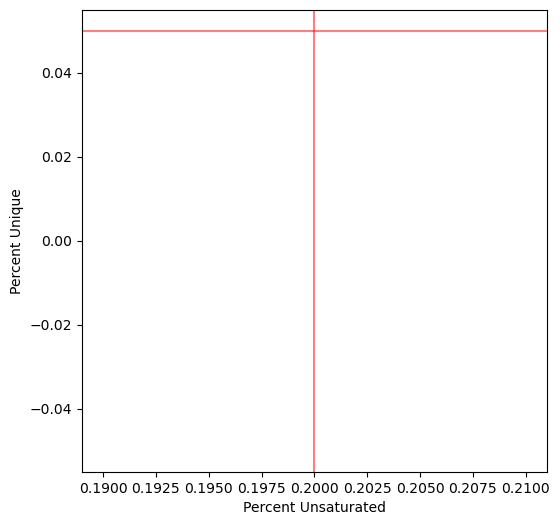

In [36]:
NUM_CELLS_THRESH = 100
PERCENT_UNIQUE_THRESH = 0.05
PERCENT_UNSATURATED_TARGETS_THRESH = 0.2

NT_primary_tumors = tumor_clone_statistics[tumor_clone_statistics.apply(lambda x: 'NT' in x.name and x.name.split("_")[2].startswith("T"), axis=1)].index

NT_clone_statistics = tumor_clone_statistics.loc[NT_primary_tumors]

low_qc = NT_clone_statistics[(NT_clone_statistics['PercentUnique'] <=PERCENT_UNIQUE_THRESH) |
                                 (NT_clone_statistics['PercentUnsaturatedTargets'] <= PERCENT_UNSATURATED_TARGETS_THRESH)].index
small = NT_clone_statistics[(NT_clone_statistics['NumCells'] < NUM_CELLS_THRESH)].index

unfiltered = np.setdiff1d(NT_primary_tumors, np.union1d(low_qc, small))

h = plt.figure(figsize=(6,6))
plt.scatter(NT_clone_statistics.loc[unfiltered, 'PercentUnsaturatedTargets'], NT_clone_statistics.loc[unfiltered, 'PercentUnique'], color='black')
plt.scatter(NT_clone_statistics.loc[low_qc, 'PercentUnsaturatedTargets'], NT_clone_statistics.loc[low_qc, 'PercentUnique'], color='red')
plt.scatter(NT_clone_statistics.loc[small, 'PercentUnsaturatedTargets'], NT_clone_statistics.loc[small, 'PercentUnique'], color='orange')


plt.axhline(y = PERCENT_UNIQUE_THRESH, color='red', alpha=0.5)
plt.axvline(x = PERCENT_UNSATURATED_TARGETS_THRESH, color='red', alpha=0.5)
plt.xlabel("Percent Unsaturated")
plt.ylabel("Percent Unique")
plt.savefig(script_dir +"/Figure/Figure1_S1/Unsaturated.png")